# Preamble

In [1]:
# data_dir = '/media/dodd/backup/transfer from Stanford/agilent_scope_data'
data_dir = '/home/dodd/data/agilent_scope_data'
from scipy import signal
%matplotlib inline

# Function definition

In [50]:
# load tektronix scope traces
def load_scope_trace(name='',data_dir=data_dir,verbose=False):
    file_list =  glob(path.normpath(data_dir)+path.normpath('/Tektronix_MSO_scope_trace_' + name + '_*'))
    latest_file = max(file_list,key=path.getctime)
    if verbose:
        print_statusline('Loading ' + name +' trace from file: ' + path.basename(path.normpath(latest_file)))
    data = np.load(latest_file)
    t = data[:,0] * u.second
    V = data[:,1] * u.volt
    return t,V

# load agilent 6GHz scope traces
def load_agilent_trace(name='',data_dir=data_dir,verbose=False):
    file_list =  glob(path.normpath(data_dir)+path.normpath('/Agilent_54855A_scope_trace_' + name + '_*'))
    latest_file = max(file_list,key=path.getctime)
    if verbose:
        print_statusline('Loading ' + name +' trace from file: ' + path.basename(path.normpath(latest_file)))
    with h5py.File(latest_file, 'r') as f:
        t0 = f['t0'][0] * u.second
        dt = f['dt'][0] * u.second
        V = f['V'][:] * u.volt
    nt = len(V)
    t = np.linspace(t0,t0+nt*dt,nt) * u.second
    return t,V

def P_Vrb_sweep_load(V_VCA_list,Vrb_list,set_name,data_dir=data_dir):
    set_dir = path.normpath(path.join(data_dir,set_name))
    # first find length of traces by loading first trace from the first Vrb value
    Vrb0 = Vrb_list[0]
    Vvca0 = V_VCA_list[0]
    t,P_ref_V0 = load_scope_trace(name='Vrb{:1.2f}_Vvca{:1.3f}_ch2_P_ref'.format(Vrb0.m,Vvca0.m),data_dir=set_dir)
    # create arrays to hold loaded data
    L = len(P_ref_V0)
    V_P_T = np.zeros((L,len(V_VCA_list),len(Vrb_list)))*u.volt
    V_P_ref = np.zeros((L,len(V_VCA_list),len(Vrb_list)))*u.volt
    V_mod = np.zeros((L,len(V_VCA_list),len(Vrb_list)))*u.volt
    V_I_TPA = np.zeros((L,len(V_VCA_list),len(Vrb_list))) *u.mA #*u.volt
    # load data into newly created arrays
    for Vind, VV in enumerate(Vrb_list):
        for Pind, PP in enumerate(V_VCA_list):
            try:
                t,V_P_T[:,Pind,Vind] =load_scope_trace(name='Vrb{:1.2f}_Vvca{:1.3f}_Vgain'.format(VV.m,PP.m),data_dir=set_dir)
                t,V_P_ref[:,Pind,Vind] = load_scope_trace(name='Vrb{:1.2f}_Vvca{:1.3f}_ch2_P_ref'.format(VV.m,PP.m),data_dir=set_dir)
                t,V_mod[:,Pind,Vind] = load_scope_trace(name='Vrb{:1.2f}_Vvca{:1.3f}_ch3_Vmod'.format(VV.m,PP.m),data_dir=set_dir)
                t,V_I_TPA[:,Pind,Vind] = load_scope_trace(name='Vrb{:1.2f}_Vvca{:1.3f}_TIAsens'.format(VV.m,PP.m),data_dir=set_dir)
            except:
                pass
            
    return {'Vrb_list':Vrb_list,'t':t,'V_P_T':V_P_T,'V_P_ref':V_P_ref,'V_mod':V_mod,'V_I_TPA':V_I_TPA,}

def Vrb_sweep_load(V_VCA_list,Vrb_list,set_name,data_dir=data_dir):
    set_dir = path.normpath(path.join(data_dir,set_name))
    print('set_dir:')
    print(set_dir)
    # first find length of traces by loading first trace from the first Vrb value
    Vrb0 = Vrb_list[0]
    Vvca0 = V_VCA_list[0]
    t,P_ref_V0 = load_scope_trace(name='Vrb{:1.1f}_tek_ch2_P_ref'.format(Vrb0.m),data_dir=set_dir)
    # create arrays to hold loaded data
    L = len(P_ref_V0)
    V_P_T = np.zeros((L,len(Vrb_list)))*u.volt
    V_P_ref = np.zeros((L,len(Vrb_list)))*u.volt
    V_mod = np.zeros((L,len(Vrb_list)))*u.volt
    V_I_TPA = np.zeros((L,len(Vrb_list))) *u.volt #*u.volt
    # load data into newly created arrays
    for Vind, VV in enumerate(Vrb_list):
        print('Vrb{:1.1f}_tek_ch1_P_trans_slow'.format(VV.m))
        print('Vrb{:1.1f}_tek_ch2_P_ref'.format(VV.m))
        t,V_P_T[:,Vind] =load_scope_trace(name='Vrb{:1.1f}_tek_ch1_P_trans_slow'.format(VV.m),data_dir=set_dir)
        t,V_P_ref[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch2_P_ref'.format(VV.m),data_dir=set_dir)
        t,V_mod[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch3_Vmod'.format(VV.m),data_dir=set_dir)
        t,V_I_TPA[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch4_I_TPA'.format(VV.m),data_dir=set_dir)

            
    return {'Vrb_list':Vrb_list,'t':t,'V_P_T':V_P_T,'V_P_ref':V_P_ref,'V_mod':V_mod,'V_I_TPA':V_I_TPA,}

def Vrb_sweep_fast_zoom_load(Vrb_list,delay_list,set_name,data_dir=data_dir):
    set_dir = path.normpath(path.join(data_dir,set_name))
    # first find length of traces by loading first trace from the first Vrb value
    Vrb0 = Vrb_list[0]
    delay0 = delay_list[0]
    nt_ag_delay = [0 for d in delay_list]
    t,P_ref_V0 = load_scope_trace(name='Vrb{:1.1f}_tek_ch2_P_ref'.format(Vrb0.m),data_dir=set_dir)
    nt_tek = len(t)
    del P_ref_V0
    t_ag,V_ag0 = load_agilent_trace(name='Vrb{:1.1f}_agilent_ch3_P_trans_fast_2018'.format(Vrb0.m),
                                        data_dir=set_dir)
    nt_ag_full = len(t_ag)
    del V_ag0
    for dind,delay in enumerate(delay_list):
        del_name = 'Vrb{:2.1f}_agilent_ch3_P_trans_fast_zoom_delay{:2.3f}'.format(Vrb0.m,delay.to(u.ms).m)
        t_ag_temp,V_ag_temp = load_agilent_trace(name=del_name,data_dir=set_dir)
        nt_ag_delay[dind] = len(t_ag_temp)
        del t_ag_temp, V_ag_temp
    
    # create arrays to hold loaded data
    V_P_T = np.zeros((nt_tek,len(Vrb_list)))*u.volt
    V_P_ref = np.zeros((nt_tek,len(Vrb_list)))*u.volt
    V_mod = np.zeros((nt_tek,len(Vrb_list)))*u.volt
    V_I_TPA = np.zeros((nt_tek,len(Vrb_list))) *u.volt 
    V_P_T_ag_slow = np.zeros((nt_ag_full,len(Vrb_list))) *u.volt 
    V_P_T_ag_fast = np.zeros((nt_ag_full,len(Vrb_list))) *u.volt
    V_P_T_zoom = [ np.zeros((nt_ag_delay[dind],len(Vrb_list))) *u.volt for dind in range(len(delay_list)) ]
    t_zoom = [ np.zeros(nt_ag_delay[dind]) *u.second for dind in range(len(delay_list)) ]
    # load data into newly created arrays
    for Vind, VV in enumerate(Vrb_list):
#         try:
        t,V_P_T[:,Vind] =load_scope_trace(name='Vrb{:1.1f}_tek_ch1_P_trans_slow'.format(VV.m),
                                               data_dir=set_dir)
        t,V_P_ref[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch2_P_ref'.format(VV.m),
                                                  data_dir=set_dir)
        t,V_mod[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch3_Vmod'.format(VV.m),
                                                data_dir=set_dir)
        t,V_I_TPA[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch4_I_TPA'.format(VV.m),
                                                  data_dir=set_dir)
        t_ag,V_P_T_ag_slow[:,Vind] = load_agilent_trace(name='Vrb{:1.1f}_agilent_ch1_P_trans_slow_2018'.format(VV.m),
                                                  data_dir=set_dir)
        t_ag,V_P_T_ag_fast[:,Vind] = load_agilent_trace(name='Vrb{:1.1f}_agilent_ch3_P_trans_fast_2018'.format(VV.m),
                                                  data_dir=set_dir)
        for dind,delay in enumerate(delay_list):
            name='Vrb{:2.1f}_agilent_ch3_P_trans_fast_zoom_delay{:2.3f}'.format(VV.m,delay.to(u.ms).m)
            t_zoom_temp,V_zoom_temp = load_agilent_trace(name=name,data_dir=set_dir)
            V_P_T_zoom[dind][:,Vind] = V_zoom_temp
            t_zoom[dind] = t_zoom_temp
    del t_zoom_temp, V_zoom_temp
#         except:
#             pass
            
    return {'Vrb_list':Vrb_list,'delay_list':delay_list,'t_ag':t_ag,'t_zoom':t_zoom,'t':t,'V_P_T':V_P_T,'V_P_ref':V_P_ref,'V_mod':V_mod,'V_I_TPA':V_I_TPA,'V_P_T_ag_slow':V_P_T_ag_slow,'V_P_T_ag_fast':V_P_T_ag_fast,'V_P_T_zoom':V_P_T_zoom,}

### fast zoom traces

In [3]:
# check zoom trace lengths
find = 2
set_dir = data_dir + '/Pf_30mW_fineV'
fnames = ['Vrb2.2_agilent_ch3_P_trans_fast_zoom_delay1.050', # len(t_load): 100169
          'Vrb0.0_agilent_ch3_P_trans_fast_zoom_delay-2.150', # len(t_load): 10019
          'Vrb0.0_agilent_ch3_P_trans_fast_2018', # len(t_load): 100169
          'Vrb2.2_agilent_ch1_P_trans_slow_2018', # len(t_load): 10016669 !!!
          'Vrb2.2_agilent_ch3_P_trans_fast_zoom_delay-2.150', # len(t_load): 10019
         ] 
          
t_load,V_load = load_agilent_trace(name=fnames[find],data_dir=set_dir)

print(f'len(t_load): {len(t_load)}')

del t_load, V_load

len(t_load): 10016669


/home/dodd/.local/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [4]:
name = fnames[0]
file_list =  glob(path.normpath(set_dir)+path.normpath('/Agilent_54855A_scope_trace_' + name + '_*'))
#print(file_list)
path.normpath(set_dir)+path.normpath('/Agilent_54855A_scope_trace_' + name + '_*')

'/home/dodd/data/agilent_scope_data/Pf_30mW_fineV/Agilent_54855A_scope_trace_Vrb2.2_agilent_ch3_P_trans_fast_zoom_delay1.050_*'

# Pf_1mW

In [51]:
# load 30mW_fineV sweep with zooms on thermal/FCO features
set_name = 'Pf_1mW'
Vmin = 0 * u.volt
Vmax = 30 * u.volt
nV = 7
# set it up
Vrb_list = np.linspace(Vmin.to(u.volt).m,Vmax.to(u.volt).m,nV) * u.volt
V_VCA_list = np.array([1.])*u.volt
ds = Vrb_sweep_load(V_VCA_list,Vrb_list,set_name,data_dir='/home/dodd/data/agilent_scope_data')

set_dir:
/home/dodd/data/agilent_scope_data/Pf_1mW
Vrb0.0_tek_ch1_P_trans_slow
Vrb0.0_tek_ch2_P_ref
Vrb5.0_tek_ch1_P_trans_slow
Vrb5.0_tek_ch2_P_ref
Vrb10.0_tek_ch1_P_trans_slow
Vrb10.0_tek_ch2_P_ref
Vrb15.0_tek_ch1_P_trans_slow
Vrb15.0_tek_ch2_P_ref
Vrb20.0_tek_ch1_P_trans_slow
Vrb20.0_tek_ch2_P_ref
Vrb25.0_tek_ch1_P_trans_slow
Vrb25.0_tek_ch2_P_ref
Vrb30.0_tek_ch1_P_trans_slow
Vrb30.0_tek_ch2_P_ref


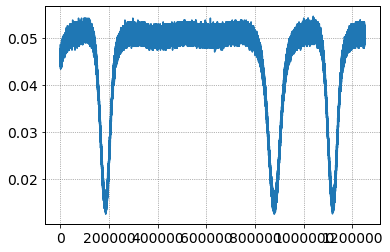

In [54]:
Vind = 0
plt.plot(ds['V_P_T'][:,Vind])
# ds['V_I_TPA'].max()

# Pf_30mW_fineV Vrb sweep with agilent zooms

In [21]:
# load 30mW_fineV sweep with zooms on thermal/FCO features
set_name = 'Pf_30mW_fineV'
delay_list = np.array([-2.15,1.05,1.5,1.9])*u.ms
Vrb_list = np.linspace(0,2.4,13)*u.volt
ds = Vrb_sweep_fast_zoom_load(Vrb_list,delay_list,set_name,data_dir=data_dir)

Vrb: 0.2 volt


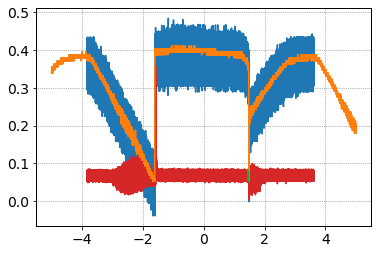

In [6]:
# plot tek and agilent data together
%matplotlib inline
Vind = 1
dind = 0
data_skip_tek = 1
data_skip_ag = 1
Vrb = Vrb_list[Vind]
printval(Vrb)

ta_lim0 = [-6,0] # ms
ta_lim1 = [0,6] # ms
ta_offs0 = 3.615*u.ms
ta_offs1 = -3.83*u.ms
tz_offs = [ta_offs0,ta_offs1,ta_offs1,ta_offs1]
ag_mask0 = (ds['t_ag'].to(u.ms).m > ta_lim0[0]) * (ds['t_ag'].to(u.ms).m < ta_lim0[1]) 
ag_mask1 = (ds['t_ag'].to(u.ms).m > ta_lim1[0]) * (ds['t_ag'].to(u.ms).m < ta_lim1[1]) 

ta0 = ds['t_ag'][ag_mask0].to(u.ms) + ta_offs0
ta1 = ds['t_ag'][ag_mask1].to(u.ms) + ta_offs1

fig,ax = plt.subplots(1,1)

ax.plot(ta0[::data_skip_ag],ds['V_P_T_ag_slow'][ag_mask0,Vind][::data_skip_ag],'C0')
ax.plot(ta0[::data_skip_ag],ds['V_P_T_ag_fast'][ag_mask0,Vind][::data_skip_ag],'C3')
ax.plot(ta1[::data_skip_ag],ds['V_P_T_ag_slow'][ag_mask1,Vind][::data_skip_ag],'C0')
ax.plot(ta1[::data_skip_ag],ds['V_P_T_ag_fast'][ag_mask1,Vind][::data_skip_ag],'C3')
ax.plot(ds['t'][::data_skip_tek].to(u.ms),ds['V_P_T'][:,Vind][::data_skip_tek],'C1')
ax.plot(ds['t_zoom'][dind].to(u.ms)+tz_offs[dind],ds['V_P_T_zoom'][dind][:,Vind][::data_skip_ag],'C2')



In [7]:
# spectrogram figure settings
fig_size = 10,6
import matplotlib.mlab as mlab
NFFT = 2**14
noverlap = 2**13
# NFFT = 2**4
# noverlap = 2**3
cmap0 = cm.viridis
cmap1 = cm.magma
vmax0 = -10
vmin0 = -13.5
vmax1 = -9
vmin1 = -12


# ylim = 4e4,6.25e5
ylim = 6e5,5e8
# fig_size = 6,3.5

# inspect spectrogram from single V_T and V_I_TPA traces
#t_mask = (d['t'].to(u.ms).m>tlim[0])*(d['t'].to(u.ms).m<tlim[1])
#x = d['t'][t_mask].to(u.ms).m - 36.16 #d['t_zero0'].to(u.ms).m
x0 = ta0.to(u.s).m
x1 = ta1.to(u.s).m
n_pts0 = len(x0)
n_pts1 = len(x1)
y0 = ds['V_P_T_ag_fast'][ag_mask0,Vind].m
y1 = ds['V_P_T_ag_fast'][ag_mask1,Vind].m

# # calculate spectrograms
f_samp = ( 1 / (ta0[1]-ta0[0])).to(u.Hz)
printval(f_samp)
# printval(n_pts)

Pxx0,freq0,ta0sp = mlab.specgram(y0,
                 NFFT=NFFT,
                 Fs=f_samp.to(u.Hz).m,
                 window=None,
                 noverlap=noverlap,
                ) 

Pxx1,freq1,ta1sp = mlab.specgram(y1,
                 NFFT=NFFT,
                 Fs=f_samp.to(u.Hz).m,
                 window=None,
                 noverlap=noverlap,
                ) 

t_offset = (ta0[0]-ta1[0]).to(u.second)

f_samp: 999999899.5 hertz


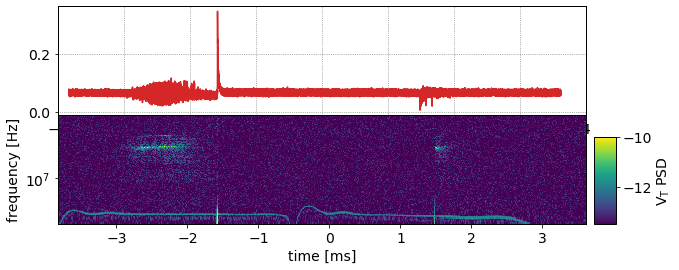

In [8]:
# plot spectrograms
skipy = 3
skipx = 30

gs = GridSpec(5,
              2,
              height_ratios=[1,0.2,0.8,0.2,0.8],
              hspace=0.,
              width_ratios=[1,0.04],
              wspace=0.03
             )

# set up figure
fig = plt.figure(figsize=fig_size)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1:3,0])
# ax2 = fig.add_subplot(gs[3:,0])

ax_cb1 = fig.add_subplot(gs[2,1])
# ax_cb2 = fig.add_subplot(gs[4,1])

# plot time traces
ax0.plot(x0[::skipx]*1e3,y0[::skipx],'C3')
ax0.plot(x1[::skipx]*1e3,y1[::skipx],'C3')
ax0.set_xlim(-4,4)

#ax0t.set_ylim([-1,12])

# plot spectrograms
p0 = ax1.pcolormesh(ta0sp*1e3+ta0[0].to(u.ms).m,
              freq0,
              np.log10(Pxx0),
              vmax=-10,
              vmin=-13.5,
              cmap=cmap0,
             )
ax1.set_xlim(ta1[0].m,ta0[-1].m)
p1 = ax1.pcolormesh(ta1sp*1e3+ta1[0].to(u.ms).m,
              freq1,
              np.log10(Pxx1),
              vmax=vmax0,
              vmin=vmin0,
              cmap=cmap0,
             )
#ax0.set_xlim(tlim)
for a in [ax1]:
    a.set_yscale('log')
    a.set_ylim(ylim)
    a.set_ylabel('frequency [Hz]')
ax1.set_xlabel('time [ms]')
cb0 = plt.colorbar(p0,
                   cax=ax_cb1,
                   label='V$_\mathrm{T}$ PSD',
                  )
# cb1 = plt.colorbar(p1,
#                    cax=ax_cb2,
#                    label='I$_\mathrm{TPA}$ PSD',
#                   )

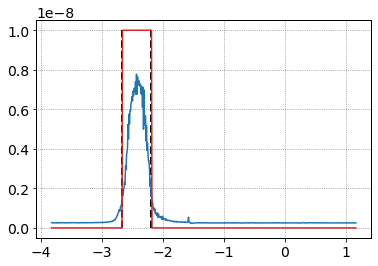

In [9]:
f_min = 1e7 # Hz
HF_power_min = 1.5e-9
f_mask = freq1 > f_min
FCO = (np.sum(Pxx1[f_mask,:],axis=0) > HF_power_min).astype('int')
t_FCO_start = ta1sp[np.argmax(np.diff(FCO))]*1e3*u.ms + +ta1[0].to(u.ms)
t_FCO_stop = ta1sp[np.argmin(np.diff(FCO))]*1e3*u.ms + +ta1[0].to(u.ms)
plt.plot(ta1sp*1e3+ta1[0].to(u.ms).m,np.sum(Pxx1[f_mask,:],axis=0))
plt.plot(ta1sp*1e3+ta1[0].to(u.ms).m,FCO.astype('int')*1e-8,'C3')
# plt.plot(ta1sp[1:]*1e3+ta1[0].to(u.ms).m,np.diff(FCO)*1e-8,'--C2')
plt.vlines((t_FCO_start.m,t_FCO_stop.m),0,1e-8,colors='k',linestyles='--',linewidths=2)

In [10]:
nV = ds['V_P_T'].shape[1]
nf = 610 # length of FCO above

f_min = 1e7 # Hz
HF_power_min = 1.5e-9
NFFT = 2**14
noverlap = 2**13

FCO_2D = np.zeros((nV,nf))
HF_2D = np.zeros((nV,nf))

ta_lim0 = [-6,0] # ms
ta_lim1 = [0,6] # ms
ta_offs0 = 3.615*u.ms
ta_offs1 = -3.83*u.ms
tz_offs = [ta_offs0,ta_offs1,ta_offs1,ta_offs1]
ag_mask0 = (ds['t_ag'].to(u.ms).m > ta_lim0[0]) * (ds['t_ag'].to(u.ms).m < ta_lim0[1]) 
ag_mask1 = (ds['t_ag'].to(u.ms).m > ta_lim1[0]) * (ds['t_ag'].to(u.ms).m < ta_lim1[1]) 

ta0 = ds['t_ag'][ag_mask0].to(u.ms) + ta_offs0
ta1 = ds['t_ag'][ag_mask1].to(u.ms) + ta_offs1



for Vind in range(nV):
    y1 = ds['V_P_T_ag_fast'][ag_mask1,Vind].m
    Pxx1,freq1,ta1sp = mlab.specgram(y1,
                 NFFT=NFFT,
                 Fs=f_samp.to(u.Hz).m,
                 window=None,
                 noverlap=noverlap,
                ) 
    f_mask = freq1 > f_min
    HF_2D[Vind,:] = np.sum(Pxx1[f_mask,:],axis=0) 
    FCO_2D[Vind,:] = (HF_2D[Vind,:] > HF_power_min).astype('int')

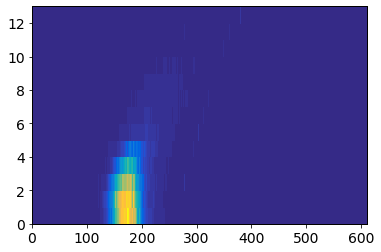

In [11]:
plt.pcolormesh(HF_2D)

In [13]:

import matplotlib.mlab as mlab



n_oversample = 1
NFFT = 2**10
noverlap = 2**9
cmap = cm.viridis

t_load = ds['t_ag']
V_load = ds['V_P_T_ag_fast'][:,Vind]

t_new = np.linspace(t_load.m.min(),t_load.m.max(),n_oversample*len(t_load)-1)
x_new = np.interp(t_new,t_load.m,V_load.m,)
f_samp = ( n_oversample / (t_load[1]-t_load[0])).to(u.Hz).m
Pxx,freq,t = mlab.specgram(x_new,
                 NFFT=NFFT,
                 Fs=f_samp,
                 window=None,
                 noverlap=noverlap,
                ) 

<IPython.core.display.Javascript object>


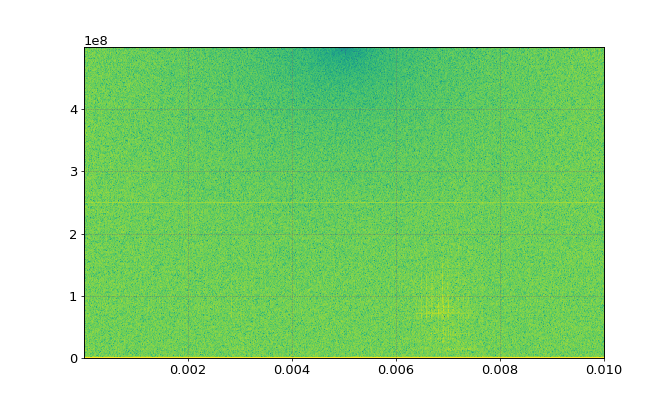

In [263]:

Vind = 7
n_oversample = 1
NFFT = 2**10
noverlap = 2**9 # 16384
cmap = cm.viridis


t_new = np.linspace(ds['t_ag'].m.min(),ds['t_ag'].m.max(),n_oversample*len(ds['t_ag'])-1)
x_new = np.interp(t_new,ds['t_ag'].m,ds['V_P_T_ag_fast'][:,Vind].m,)
f_samp = ( n_oversample / (ds['t_ag'][1]-ds['t_ag'][0])).to(u.Hz).m

fig,ax = plt.subplots(1,1)
sg = ax.specgram(x_new,
                 NFFT=NFFT,
                 Fs=f_samp,
                 window=None,
                 noverlap=noverlap,
                 cmap=cmap,
                 scale='dB',
                 vmax=-105,
                ) 



<IPython.core.display.Javascript object>


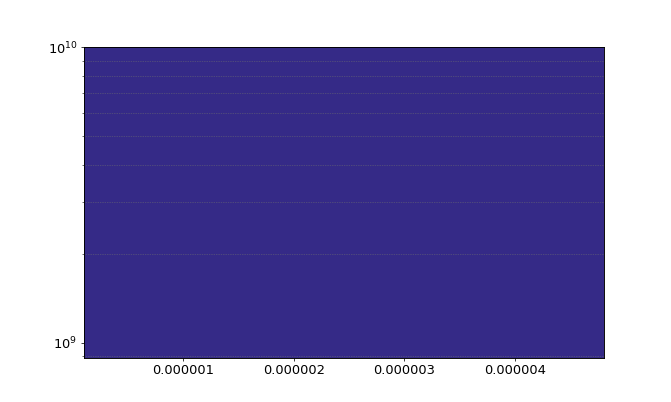

In [248]:
import matplotlib.mlab as mlab

dind = 3
NFFT = 2**12
noverlap = 2**11 # 16384
cmap = parula
n_oversample=1


x = ds['V_P_T_zoom'][dind][:,Vind]
f_samp = ( n_oversample / (ds['t_zoom'][dind][1]-ds['t_zoom'][dind][0])).to(u.Hz).m


Pxx,freq,t = mlab.specgram(x,
                 NFFT=NFFT,
                 Fs=f_samp,
                 window=None,
                 noverlap=noverlap,
#                  scale='linear',
                ) 



<IPython.core.display.Javascript object>


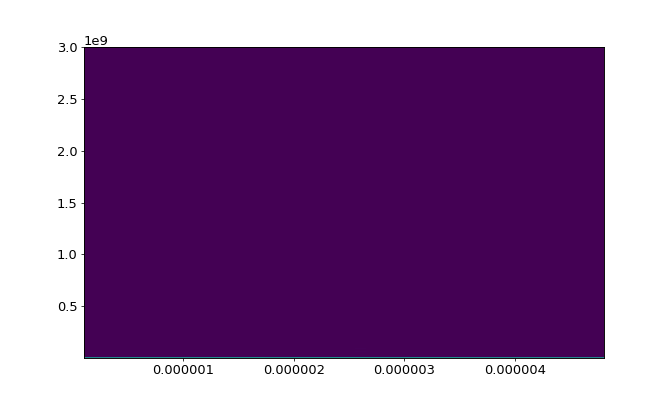

(3000.0, 3000000000.0)

In [251]:
fig,ax = plt.subplots(1,1)

p = ax.pcolor(t,freq,Pxx,cmap=cm.viridis,)
#ax.set_yscale('log')
ax.set_ylim(3e3,3e9)

In [264]:
del ds

# Pf_50mW with zooms

In [5]:
# load

set_name ='Pf_50mW'
Vmin = 0 * u.volt
Vmax = 30 * u.volt
nV = 7
Vrb_list = np.linspace(Vmin.to(u.volt).m,Vmax.to(u.volt).m,nV) * u.volt
delay_list = [1*u.ms,2*u.ms,3*u.ms,4*u.ms]
ds = Vrb_sweep_fast_zoom_load(Vrb_list[:3],delay_list,set_name,data_dir=data_dir)


Vrb: 0.0 volt


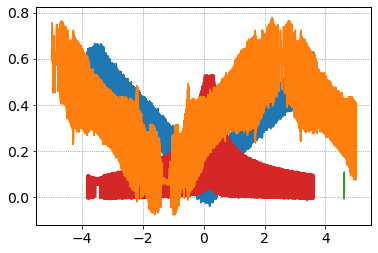

In [6]:
# plot tek and agilent data together
%matplotlib inline
Vind = 0
dind = 0
data_skip_tek = 1
data_skip_ag = 1
Vrb = Vrb_list[Vind]
printval(Vrb)

ta_lim0 = [-6,0] # ms
ta_lim1 = [0,6] # ms
ta_offs0 = 3.615*u.ms
ta_offs1 = -3.83*u.ms
tz_offs = [ta_offs0,ta_offs1,ta_offs1,ta_offs1]
ag_mask0 = (ds['t_ag'].to(u.ms).m > ta_lim0[0]) * (ds['t_ag'].to(u.ms).m < ta_lim0[1]) 
ag_mask1 = (ds['t_ag'].to(u.ms).m > ta_lim1[0]) * (ds['t_ag'].to(u.ms).m < ta_lim1[1]) 

ta0 = ds['t_ag'][ag_mask0].to(u.ms) + ta_offs0
ta1 = ds['t_ag'][ag_mask1].to(u.ms) + ta_offs1

fig,ax = plt.subplots(1,1)

ax.plot(ta0[::data_skip_ag],ds['V_P_T_ag_slow'][ag_mask0,Vind][::data_skip_ag],'C0')
ax.plot(ta0[::data_skip_ag],ds['V_P_T_ag_fast'][ag_mask0,Vind][::data_skip_ag],'C3')
ax.plot(ta1[::data_skip_ag],ds['V_P_T_ag_slow'][ag_mask1,Vind][::data_skip_ag],'C0')
ax.plot(ta1[::data_skip_ag],ds['V_P_T_ag_fast'][ag_mask1,Vind][::data_skip_ag],'C3')
ax.plot(ds['t'][::data_skip_tek].to(u.ms),ds['V_P_T'][:,Vind][::data_skip_tek],'C1')
ax.plot(ds['t_zoom'][dind].to(u.ms)+tz_offs[dind],ds['V_P_T_zoom'][dind][:,Vind][::data_skip_ag],'C2')





In [7]:
# spectrogram figure settings
fig_size = 10,6
import matplotlib.mlab as mlab
NFFT = 2**14
noverlap = 2**13
# NFFT = 2**4
# noverlap = 2**3
cmap0 = cm.viridis
cmap1 = cm.magma
vmax0 = -10
vmin0 = -13.5
vmax1 = -9
vmin1 = -12


# ylim = 4e4,6.25e5
ylim = 6e5,5e8
# fig_size = 6,3.5

# inspect spectrogram from single V_T and V_I_TPA traces
#t_mask = (d['t'].to(u.ms).m>tlim[0])*(d['t'].to(u.ms).m<tlim[1])
#x = d['t'][t_mask].to(u.ms).m - 36.16 #d['t_zero0'].to(u.ms).m
x0 = ta0.to(u.s).m
x1 = ta1.to(u.s).m
n_pts0 = len(x0)
n_pts1 = len(x1)
y0 = ds['V_P_T_ag_fast'][ag_mask0,Vind].m
y1 = ds['V_P_T_ag_fast'][ag_mask1,Vind].m

# # calculate spectrograms
f_samp = ( 1 / (ta0[1]-ta0[0])).to(u.Hz)
printval(f_samp)
# printval(n_pts)

Pxx0,freq0,ta0sp = mlab.specgram(y0,
                 NFFT=NFFT,
                 Fs=f_samp.to(u.Hz).m,
                 window=None,
                 noverlap=noverlap,
                ) 

Pxx1,freq1,ta1sp = mlab.specgram(y1,
                 NFFT=NFFT,
                 Fs=f_samp.to(u.Hz).m,
                 window=None,
                 noverlap=noverlap,
                ) 

t_offset = (ta0[0]-ta1[0]).to(u.second)

f_samp: 999999899.5 hertz


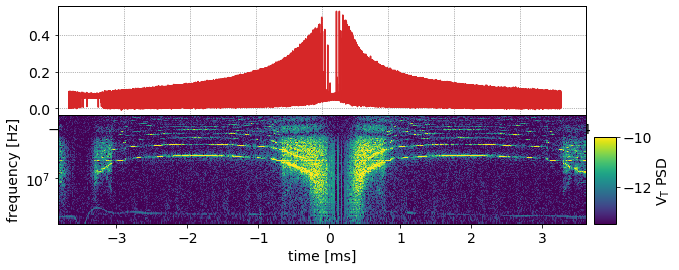

In [8]:
# plot spectrograms
skipy = 3
skipx = 30

gs = GridSpec(5,
              2,
              height_ratios=[1,0.2,0.8,0.2,0.8],
              hspace=0.,
              width_ratios=[1,0.04],
              wspace=0.03
             )

# set up figure
fig = plt.figure(figsize=fig_size)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1:3,0])
# ax2 = fig.add_subplot(gs[3:,0])

ax_cb1 = fig.add_subplot(gs[2,1])
# ax_cb2 = fig.add_subplot(gs[4,1])

# plot time traces
ax0.plot(x0[::skipx]*1e3,y0[::skipx],'C3')
ax0.plot(x1[::skipx]*1e3,y1[::skipx],'C3')
ax0.set_xlim(-4,4)

#ax0t.set_ylim([-1,12])

# plot spectrograms
p0 = ax1.pcolormesh(ta0sp*1e3+ta0[0].to(u.ms).m,
              freq0,
              np.log10(Pxx0),
              vmax=-10,
              vmin=-13.5,
              cmap=cmap0,
             )
ax1.set_xlim(ta1[0].m,ta0[-1].m)
p1 = ax1.pcolormesh(ta1sp*1e3+ta1[0].to(u.ms).m,
              freq1,
              np.log10(Pxx1),
              vmax=vmax0,
              vmin=vmin0,
              cmap=cmap0,
             )
#ax0.set_xlim(tlim)
for a in [ax1]:
    a.set_yscale('log')
    a.set_ylim(ylim)
    a.set_ylabel('frequency [Hz]')
ax1.set_xlabel('time [ms]')
cb0 = plt.colorbar(p0,
                   cax=ax_cb1,
                   label='V$_\mathrm{T}$ PSD',
                  )
# cb1 = plt.colorbar(p1,
#                    cax=ax_cb2,
#                    label='I$_\mathrm{TPA}$ PSD',
#                   )

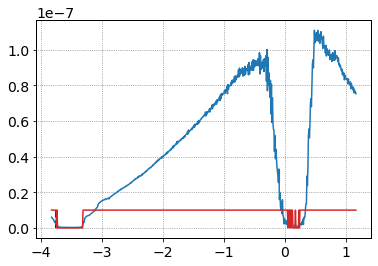

In [9]:
f_min = 1e7 # Hz
HF_power_min = 1.5e-9
f_mask = freq1 > f_min
FCO = (np.sum(Pxx1[f_mask,:],axis=0) > HF_power_min).astype('int')
t_FCO_start = ta1sp[np.argmax(np.diff(FCO))]*1e3*u.ms + +ta1[0].to(u.ms)
t_FCO_stop = ta1sp[np.argmin(np.diff(FCO))]*1e3*u.ms + +ta1[0].to(u.ms)
plt.plot(ta1sp*1e3+ta1[0].to(u.ms).m,np.sum(Pxx1[f_mask,:],axis=0))
plt.plot(ta1sp*1e3+ta1[0].to(u.ms).m,FCO.astype('int')*1e-8,'C3')
# plt.plot(ta1sp[1:]*1e3+ta1[0].to(u.ms).m,np.diff(FCO)*1e-8,'--C2')
plt.vlines((t_FCO_start.m,t_FCO_stop.m),0,1e-8,colors='k',linestyles='--',linewidths=2)

In [10]:
# calculate FCO for full dataset
nV = ds['V_P_T'].shape[1]
nf = 610 # length of FCO above

f_min = 1e7 # Hz
HF_power_min = 1.5e-9
NFFT = 2**14
noverlap = 2**13

FCO_2D = np.zeros((nV,nf))
HF_2D = np.zeros((nV,nf))

ta_lim0 = [-6,0] # ms
ta_lim1 = [0,6] # ms
ta_offs0 = 3.615*u.ms
ta_offs1 = -3.83*u.ms
tz_offs = [ta_offs0,ta_offs1,ta_offs1,ta_offs1]
ag_mask0 = (ds['t_ag'].to(u.ms).m > ta_lim0[0]) * (ds['t_ag'].to(u.ms).m < ta_lim0[1]) 
ag_mask1 = (ds['t_ag'].to(u.ms).m > ta_lim1[0]) * (ds['t_ag'].to(u.ms).m < ta_lim1[1]) 

ta0 = ds['t_ag'][ag_mask0].to(u.ms) + ta_offs0
ta1 = ds['t_ag'][ag_mask1].to(u.ms) + ta_offs1



for Vind in range(nV):
    y1 = ds['V_P_T_ag_fast'][ag_mask1,Vind].m
    Pxx1,freq1,ta1sp = mlab.specgram(y1,
                 NFFT=NFFT,
                 Fs=f_samp.to(u.Hz).m,
                 window=None,
                 noverlap=noverlap,
                ) 
    f_mask = freq1 > f_min
    HF_2D[Vind,:] = np.sum(Pxx1[f_mask,:],axis=0) 
    FCO_2D[Vind,:] = (HF_2D[Vind,:] > HF_power_min).astype('int')

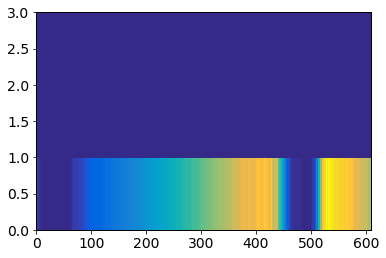

In [20]:
plt.pcolormesh(HF_2D)

Vrb: 0.0 volt


<IPython.core.display.Javascript object>


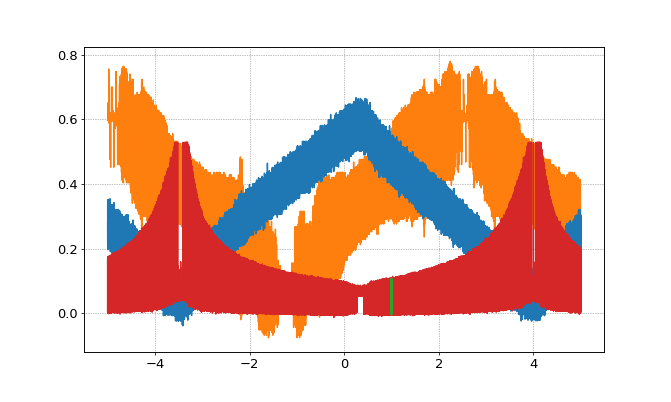

In [6]:
# plot
%matplotlib notebook
Vind = 0
dind = 0
data_skip_tek = 1
data_skip_ag = 1
Vrb = Vrb_list[Vind]
printval(Vrb)

fig,ax = plt.subplots(1,1)
ax.plot(ds['t'][::data_skip_tek].to(u.ms),ds['V_P_T'][:,Vind][::data_skip_tek],'C1')
ax.plot(ds['t_ag'][::data_skip_ag].to(u.ms),ds['V_P_T_ag_slow'][:,Vind][::data_skip_ag],'C0')
ax.plot(ds['t_ag'][::data_skip_ag].to(u.ms),ds['V_P_T_ag_fast'][:,Vind][::data_skip_ag],'C3')
ax.plot(ds['t_zoom'][dind].to(u.ms),ds['V_P_T_zoom'][dind][:,Vind][::data_skip_ag],'C2')




<IPython.core.display.Javascript object>


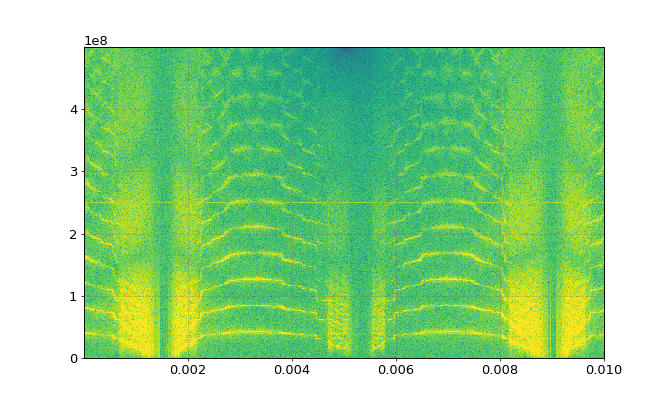

In [16]:
Vind = 0
n_oversample = 1
NFFT = 2**14
noverlap = 2**13
cmap = cm.viridis


t_new = np.linspace(ds['t_ag'].m.min(),ds['t_ag'].m.max(),n_oversample*len(ds['t_ag'])-1)
x_new = np.interp(t_new,ds['t_ag'].m,ds['V_P_T_ag_fast'][:,Vind].m,)
f_samp = ( n_oversample / (ds['t_ag'][1]-ds['t_ag'][0])).to(u.Hz).m

fig,ax = plt.subplots(1,1)
sg = ax.specgram(x_new,
                 NFFT=NFFT,
                 Fs=f_samp,
                 window=None,
                 noverlap=noverlap,
                 cmap=cmap,
                 scale='dB',
                 vmax=-105,
                ) 



In [17]:
del ds

# Pf_40mW with zooms

In [3]:
# load

set_name ='Pf_40mW'
Vmin = 0 * u.volt
Vmax = 30 * u.volt
nV = 7
Vrb_list = np.linspace(Vmin.to(u.volt).m,Vmax.to(u.volt).m,nV) * u.volt
delay_list = [-1.25*u.ms,1.05*u.ms,1.35*u.ms,1.95*u.ms,2.8*u.ms]
ds = Vrb_sweep_fast_zoom_load(Vrb_list[:2],delay_list,set_name,data_dir=data_dir)


/home/dodd/.local/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


Vrb: 0.0 volt


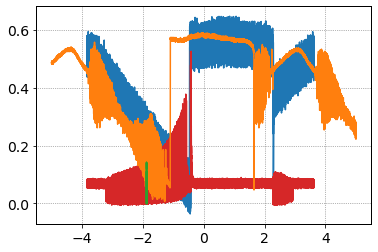

In [11]:
# plot tek and agilent data together
%matplotlib inline
Vind = 0
dind = 3
data_skip_tek = 1
data_skip_ag = 1
Vrb = Vrb_list[Vind]
printval(Vrb)

ta_lim0 = [-6,0] # ms
ta_lim1 = [0,6] # ms
ta_offs0 = 3.615*u.ms
ta_offs1 = -3.83*u.ms
tz_offs = [ta_offs0,ta_offs1,ta_offs1,ta_offs1]
ag_mask0 = (ds['t_ag'].to(u.ms).m > ta_lim0[0]) * (ds['t_ag'].to(u.ms).m < ta_lim0[1]) 
ag_mask1 = (ds['t_ag'].to(u.ms).m > ta_lim1[0]) * (ds['t_ag'].to(u.ms).m < ta_lim1[1]) 

ta0 = ds['t_ag'][ag_mask0].to(u.ms) + ta_offs0
ta1 = ds['t_ag'][ag_mask1].to(u.ms) + ta_offs1

fig,ax = plt.subplots(1,1)

ax.plot(ta0[::data_skip_ag],ds['V_P_T_ag_slow'][ag_mask0,Vind][::data_skip_ag],'C0')
ax.plot(ta0[::data_skip_ag],ds['V_P_T_ag_fast'][ag_mask0,Vind][::data_skip_ag],'C3')
ax.plot(ta1[::data_skip_ag],ds['V_P_T_ag_slow'][ag_mask1,Vind][::data_skip_ag],'C0')
ax.plot(ta1[::data_skip_ag],ds['V_P_T_ag_fast'][ag_mask1,Vind][::data_skip_ag],'C3')
ax.plot(ds['t'][::data_skip_tek].to(u.ms),ds['V_P_T'][:,Vind][::data_skip_tek],'C1')
ax.plot(ds['t_zoom'][dind].to(u.ms)+tz_offs[dind],ds['V_P_T_zoom'][dind][:,Vind][::data_skip_ag],'C2')





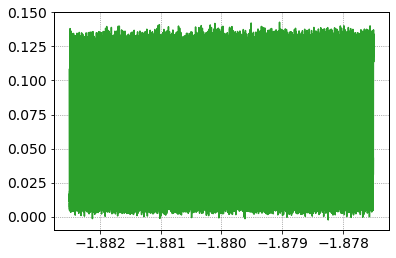

In [20]:
dind = 3
plt.plot(ds['t_zoom'][dind].to(u.ms)+tz_offs[dind],ds['V_P_T_zoom'][dind][:,Vind][::data_skip_ag],'C2')
ax = plt.gca()
# ax.set_xlim([-2.78,-2.7799])
#ax.set_xlim([-1.88,-1.8799])
# ax.set_xlim([-2.48,-2.4799])

In [5]:
# spectrogram figure settings
fig_size = 10,6
import matplotlib.mlab as mlab
NFFT = 2**14
noverlap = 2**13
# NFFT = 2**4
# noverlap = 2**3
cmap0 = cm.viridis
cmap1 = cm.magma
vmax0 = -10
vmin0 = -13.5
vmax1 = -9
vmin1 = -12


# ylim = 4e4,6.25e5
ylim = 6e5,5e8
# fig_size = 6,3.5

# inspect spectrogram from single V_T and V_I_TPA traces
#t_mask = (d['t'].to(u.ms).m>tlim[0])*(d['t'].to(u.ms).m<tlim[1])
#x = d['t'][t_mask].to(u.ms).m - 36.16 #d['t_zero0'].to(u.ms).m
x0 = ta0.to(u.s).m
x1 = ta1.to(u.s).m
n_pts0 = len(x0)
n_pts1 = len(x1)
y0 = ds['V_P_T_ag_fast'][ag_mask0,Vind].m
y1 = ds['V_P_T_ag_fast'][ag_mask1,Vind].m

# # calculate spectrograms
f_samp = ( 1 / (ta0[1]-ta0[0])).to(u.Hz)
printval(f_samp)
# printval(n_pts)

Pxx0,freq0,ta0sp = mlab.specgram(y0,
                 NFFT=NFFT,
                 Fs=f_samp.to(u.Hz).m,
                 window=None,
                 noverlap=noverlap,
                ) 

Pxx1,freq1,ta1sp = mlab.specgram(y1,
                 NFFT=NFFT,
                 Fs=f_samp.to(u.Hz).m,
                 window=None,
                 noverlap=noverlap,
                ) 

t_offset = (ta0[0]-ta1[0]).to(u.second)

f_samp: 999999900.4 hertz


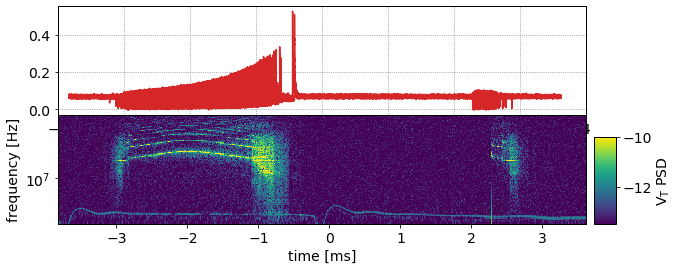

In [24]:
# plot spectrograms
skipy = 3
skipx = 30

gs = GridSpec(5,
              2,
              height_ratios=[1,0.2,0.8,0.2,0.8],
              hspace=0.,
              width_ratios=[1,0.04],
              wspace=0.03
             )

# set up figure
fig = plt.figure(figsize=fig_size)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1:3,0])
# ax2 = fig.add_subplot(gs[3:,0])

ax_cb1 = fig.add_subplot(gs[2,1])
# ax_cb2 = fig.add_subplot(gs[4,1])

# plot time traces
ax0.plot(x0[::skipx]*1e3,y0[::skipx],'C3')
ax0.plot(x1[::skipx]*1e3,y1[::skipx],'C3')
ax0.set_xlim(-4,4)

#ax0t.set_ylim([-1,12])

# plot spectrograms
p0 = ax1.pcolormesh(ta0sp*1e3+ta0[0].to(u.ms).m,
              freq0,
              np.log10(Pxx0),
              vmax=-10,
              vmin=-13.5,
              cmap=cmap0,
             )
ax1.set_xlim(ta1[0].m,ta0[-1].m)
p1 = ax1.pcolormesh(ta1sp*1e3+ta1[0].to(u.ms).m,
              freq1,
              np.log10(Pxx1),
              vmax=vmax0,
              vmin=vmin0,
              cmap=cmap0,
             )
#ax0.set_xlim(tlim)
for a in [ax1]:
    a.set_yscale('log')
    a.set_ylim(ylim)
    a.set_ylabel('frequency [Hz]')
ax1.set_xlabel('time [ms]')
cb0 = plt.colorbar(p0,
                   cax=ax_cb1,
                   label='V$_\mathrm{T}$ PSD',
                  )
# cb1 = plt.colorbar(p1,
#                    cax=ax_cb2,
#                    label='I$_\mathrm{TPA}$ PSD',
#                   )

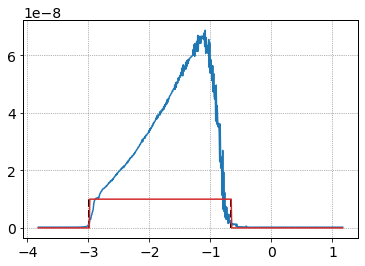

In [25]:
f_min = 1e7 # Hz
HF_power_min = 1.5e-9
f_mask = freq1 > f_min
FCO = (np.sum(Pxx1[f_mask,:],axis=0) > HF_power_min).astype('int')
t_FCO_start = ta1sp[np.argmax(np.diff(FCO))]*1e3*u.ms + +ta1[0].to(u.ms)
t_FCO_stop = ta1sp[np.argmin(np.diff(FCO))]*1e3*u.ms + +ta1[0].to(u.ms)
plt.plot(ta1sp*1e3+ta1[0].to(u.ms).m,np.sum(Pxx1[f_mask,:],axis=0))
plt.plot(ta1sp*1e3+ta1[0].to(u.ms).m,FCO.astype('int')*1e-8,'C3')
# plt.plot(ta1sp[1:]*1e3+ta1[0].to(u.ms).m,np.diff(FCO)*1e-8,'--C2')
plt.vlines((t_FCO_start.m,t_FCO_stop.m),0,1e-8,colors='k',linestyles='--',linewidths=2)

In [26]:
# calculate FCO for full dataset
nV = ds['V_P_T'].shape[1]
nf = 610 # length of FCO above

f_min = 1e7 # Hz
HF_power_min = 1.5e-9
NFFT = 2**14
noverlap = 2**13

FCO_2D = np.zeros((nV,nf))
HF_2D = np.zeros((nV,nf))

ta_lim0 = [-6,0] # ms
ta_lim1 = [0,6] # ms
ta_offs0 = 3.615*u.ms
ta_offs1 = -3.83*u.ms
tz_offs = [ta_offs0,ta_offs1,ta_offs1,ta_offs1]
ag_mask0 = (ds['t_ag'].to(u.ms).m > ta_lim0[0]) * (ds['t_ag'].to(u.ms).m < ta_lim0[1]) 
ag_mask1 = (ds['t_ag'].to(u.ms).m > ta_lim1[0]) * (ds['t_ag'].to(u.ms).m < ta_lim1[1]) 

ta0 = ds['t_ag'][ag_mask0].to(u.ms) + ta_offs0
ta1 = ds['t_ag'][ag_mask1].to(u.ms) + ta_offs1



for Vind in range(nV):
    y1 = ds['V_P_T_ag_fast'][ag_mask1,Vind].m
    Pxx1,freq1,ta1sp = mlab.specgram(y1,
                 NFFT=NFFT,
                 Fs=f_samp.to(u.Hz).m,
                 window=None,
                 noverlap=noverlap,
                ) 
    f_mask = freq1 > f_min
    HF_2D[Vind,:] = np.sum(Pxx1[f_mask,:],axis=0) 
    FCO_2D[Vind,:] = (HF_2D[Vind,:] > HF_power_min).astype('int')

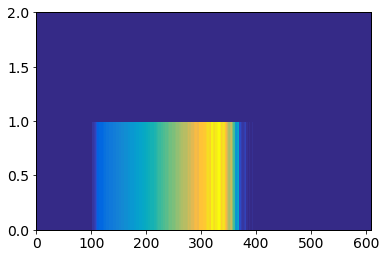

In [27]:
plt.pcolormesh(HF_2D)

In [ ]:
%

Vrb: 0.0 volt


<IPython.core.display.Javascript object>


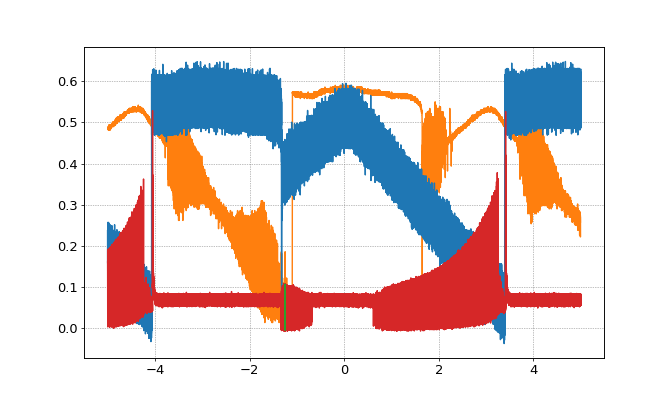

In [19]:
# plot
Vind = 0
dind = 0
data_skip_tek = 1
data_skip_ag = 1
Vrb = Vrb_list[Vind]
printval(Vrb)

fig,ax = plt.subplots(1,1)
ax.plot(ds['t'][::data_skip_tek].to(u.ms),ds['V_P_T'][:,Vind][::data_skip_tek],'C1')
ax.plot(ds['t_ag'][::data_skip_ag].to(u.ms),ds['V_P_T_ag_slow'][:,Vind][::data_skip_ag],'C0')
ax.plot(ds['t_ag'][::data_skip_ag].to(u.ms),ds['V_P_T_ag_fast'][:,Vind][::data_skip_ag],'C3')
ax.plot(ds['t_zoom'][dind].to(u.ms),ds['V_P_T_zoom'][dind][:,Vind][::data_skip_ag],'C2')


<IPython.core.display.Javascript object>


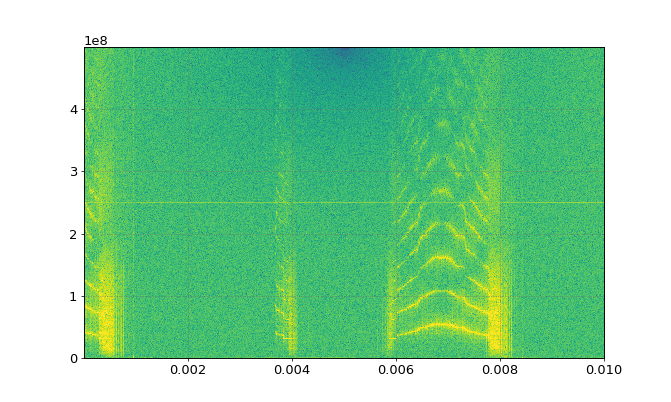

In [21]:
Vind = 0
n_oversample = 1
NFFT = 2**12
noverlap = 2**11
cmap = cm.viridis


t_new = np.linspace(ds['t_ag'].m.min(),ds['t_ag'].m.max(),n_oversample*len(ds['t_ag'])-1)
x_new = np.interp(t_new,ds['t_ag'].m,ds['V_P_T_ag_fast'][:,Vind].m,)
f_samp = ( n_oversample / (ds['t_ag'][1]-ds['t_ag'][0])).to(u.Hz).m

fig,ax = plt.subplots(1,1)
sg = ax.specgram(x_new,
                 NFFT=NFFT,
                 Fs=f_samp,
                 window=None,
                 noverlap=noverlap,
                 cmap=cmap,
                 scale='dB',
                 vmax=-105,
                ) 

In [22]:
del ds

# Pf_* data

In [34]:
set_name = 'Pf_500uW'
Vmin = 0 * u.volt
Vmax = 30 * u.volt
nV = 7
Vrb_list = np.linspace(Vmin.to(u.volt).m,Vmax.to(u.volt).m,nV) * u.volt


set_dir = path.normpath(path.join(data_dir,set_name))
# first find length of traces by loading first trace from the first Vrb value
Vrb0 = Vrb_list[0]
t,P_ref_V0 = load_scope_trace(name='Vrb{:1.1f}_tek_ch2_P_ref'.format(Vrb0.m),data_dir=set_dir)
# create arrays to hold loaded data
L = len(P_ref_V0)
V_P_T = np.zeros((L,len(Vrb_list)))*u.volt
V_P_ref = np.zeros((L,len(Vrb_list)))*u.volt
V_mod = np.zeros((L,len(Vrb_list)))*u.volt
V_I_TPA = np.zeros((L,len(Vrb_list))) *u.volt #*u.volt
# load data into newly created arrays
for Vind, VV in enumerate(Vrb_list):
#     try:
    t,V_P_T[:,Vind] =load_scope_trace(name='Vrb{:1.1f}_tek_ch1_P_trans_slow'.format(VV.m,),data_dir=set_dir)
    t,V_P_ref[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch2_P_ref'.format(VV.m,),data_dir=set_dir)
    t,V_mod[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch3_Vmod'.format(VV.m,),data_dir=set_dir)
    t,V_I_TPA[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch4_I_TPA'.format(VV.m,),data_dir=set_dir)
#     except:
#         pass

ds= {'Vrb_list':Vrb_list,'t':t,'V_P_T':V_P_T,'V_P_ref':V_P_ref,'V_mod':V_mod,'V_I_TPA':V_I_TPA,}


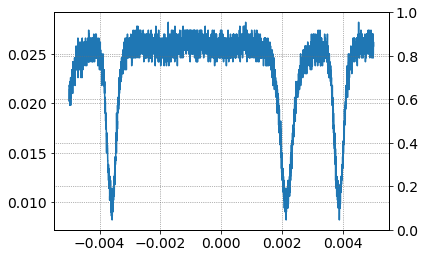

In [33]:
data_skip = 300
Vind = 4
x = ds['t'][::data_skip]
y0 = ds['V_P_T'][::data_skip,Vind]
y1 = ds['V_I_TPA'][::data_skip,Vind]

fig,ax = plt.subplots(1,1)
axt = ax.twinx()
ax.plot(x,y0,'C0')
# axt.plot(x,y1,'C3')

In [35]:
set_name = 'Pf_70uW'
Vmin = 0 * u.volt
Vmax = 30 * u.volt
nV = 31
Vrb_list = np.linspace(Vmin.to(u.volt).m,Vmax.to(u.volt).m,nV) * u.volt


set_dir = path.normpath(path.join(data_dir,set_name))
# first find length of traces by loading first trace from the first Vrb value
Vrb0 = Vrb_list[0]
t,P_ref_V0 = load_scope_trace(name='Vrb{:1.1f}_tek_ch2_P_ref'.format(Vrb0.m),data_dir=set_dir)
# create arrays to hold loaded data
L = len(P_ref_V0)
V_P_T = np.zeros((L,len(Vrb_list)))*u.volt
V_P_ref = np.zeros((L,len(Vrb_list)))*u.volt
V_mod = np.zeros((L,len(Vrb_list)))*u.volt
V_I_TPA = np.zeros((L,len(Vrb_list))) *u.volt #*u.volt
# load data into newly created arrays
for Vind, VV in enumerate(Vrb_list):
#     try:
    t,V_P_T[:,Vind] =load_scope_trace(name='Vrb{:1.1f}_tek_ch1_P_trans_slow'.format(VV.m,),data_dir=set_dir)
    t,V_P_ref[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch2_P_ref'.format(VV.m,),data_dir=set_dir)
    t,V_mod[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch3_Vmod'.format(VV.m,),data_dir=set_dir)
    t,V_I_TPA[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch4_I_TPA'.format(VV.m,),data_dir=set_dir)
#     except:
#         pass

ds= {'Vrb_list':Vrb_list,'t':t,'V_P_T':V_P_T,'V_P_ref':V_P_ref,'V_mod':V_mod,'V_I_TPA':V_I_TPA,}


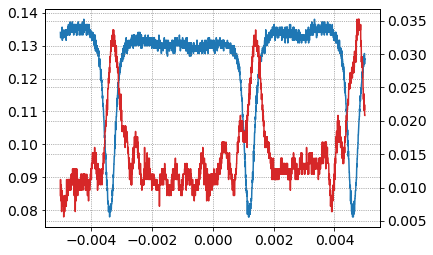

In [42]:
data_skip = 50
Vind = 1
x = ds['t'][::data_skip]
y0 = ds['V_P_T'][::data_skip,Vind]
y1 = ds['V_I_TPA'][::data_skip,Vind]

fig,ax = plt.subplots(1,1)
axt = ax.twinx()
ax.plot(x,y0,'C0')
axt.plot(x,y1,'C3')

In [46]:
set_name = 'Pf_30mW'
Vmin = 0 * u.volt
Vmax = 30 * u.volt
nV = 7
Vrb_list = np.linspace(Vmin.to(u.volt).m,Vmax.to(u.volt).m,nV) * u.volt


set_dir = path.normpath(path.join(data_dir,set_name))
# first find length of traces by loading first trace from the first Vrb value
Vrb0 = Vrb_list[0]
t,P_ref_V0 = load_scope_trace(name='Vrb{:1.1f}_tek_ch2_P_ref'.format(Vrb0.m),data_dir=set_dir)
# create arrays to hold loaded data
L = len(P_ref_V0)
V_P_T = np.zeros((L,len(Vrb_list)))*u.volt
V_P_ref = np.zeros((L,len(Vrb_list)))*u.volt
V_mod = np.zeros((L,len(Vrb_list)))*u.volt
V_I_TPA = np.zeros((L,len(Vrb_list))) *u.volt #*u.volt
# load data into newly created arrays
for Vind, VV in enumerate(Vrb_list):
#     try:
    t,V_P_T[:,Vind] =load_scope_trace(name='Vrb{:1.1f}_tek_ch1_P_trans_slow'.format(VV.m,),data_dir=set_dir)
    t,V_P_ref[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch2_P_ref'.format(VV.m,),data_dir=set_dir)
    t,V_mod[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch3_Vmod'.format(VV.m,),data_dir=set_dir)
    t,V_I_TPA[:,Vind] = load_scope_trace(name='Vrb{:1.1f}_tek_ch4_I_TPA'.format(VV.m,),data_dir=set_dir)
#     except:
#         pass

ds= {'Vrb_list':Vrb_list,'t':t,'V_P_T':V_P_T,'V_P_ref':V_P_ref,'V_mod':V_mod,'V_I_TPA':V_I_TPA,}

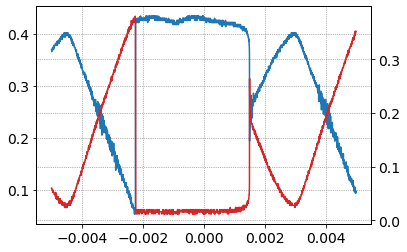

In [50]:
data_skip = 50
Vind = 0
x = ds['t'][::data_skip]
y0 = ds['V_P_T'][::data_skip,Vind]
y1 = ds['V_I_TPA'][::data_skip,Vind]

fig,ax = plt.subplots(1,1)
axt = ax.twinx()
ax.plot(x,y0,'C0')
axt.plot(x,y1,'C3')

# sustained oscillation traces

Text(0.5, 0, 'time [ns]')

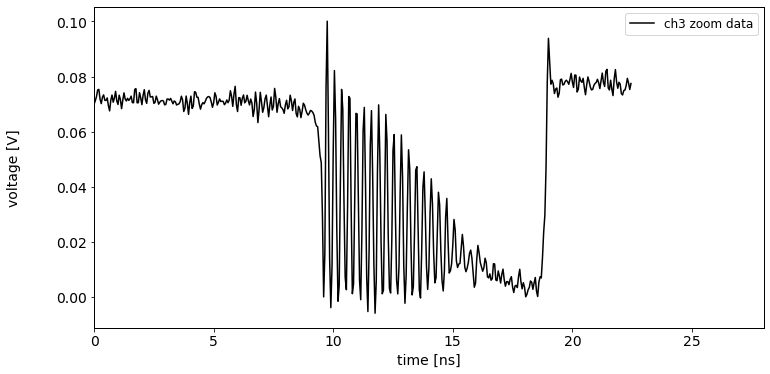

In [51]:
# plot sustained oscillation trace to check

#t_load,V_load = load_agilent_trace(name='sustained_osc_Vrb0_agilent_ch3_P_trans_fast',)
#t_load,V_load = load_agilent_trace(name='sustained_osc_Vrb1_agilent_ch3_P_trans_fast',)
#t_load,V_load = load_agilent_trace(name='sustained_osc_Vrb2_agilent_ch3_P_trans_fast',)
#t_load,V_load = load_agilent_trace(name='sustained_osc_Pf100mW_Vrb2_agilent_ch3_P_trans_fast',)
#t_load,V_load = load_agilent_trace(name='sustained_osc_Pf100mW_Vrb1_agilent_ch3_P_trans_fast',)
#t_load,V_load = load_agilent_trace(name='sustained_osc_Pf100mW_Vrb0_agilent_ch3_P_trans_fast',)
t_load,V_load = load_agilent_trace(name='sustained_osc_Pf200mW_Vrb0_agilent_ch3_P_trans_fast',)
#t_load,V_load = load_agilent_trace(name='sustained_osc_Pf200mW_Vrb1_agilent_ch3_P_trans_fast',)
#t_load,V_load = load_agilent_trace(name='sustained_osc_Pf200mW_Vrb2_agilent_ch3_P_trans_fast',)


# plot agilent scope test data 
data_skip=1

fig = plt.figure(figsize=(12,13))
gs = GridSpec(2,1)
ax0 = fig.add_subplot(gs[0])

trace_len = len(t_load)
zoom_len = 900
#zoom_offset = 18 * u.ns
t_plot = t_load[int(trace_len/2-zoom_len/2):int(trace_len/2+zoom_len/2)].to(u.ns) - t_load[int(trace_len/2)].to(u.ns)
V_plot = V_load[int(trace_len/2-zoom_len/2):int(trace_len/2+zoom_len/2)]
ax0.plot(t_plot,V_plot,color='k',label='ch3 zoom data')
#ax0.plot(t3_load[::data_skip].to(u.us),V3_load[::data_skip],color='C3',label='ch3 test data')
del t_load
del V_load
ax0.set_xlim([0,28])

ax0.grid()
ax0.legend()
ax0.set_ylabel('voltage [V]',labelpad=35)
ax0.set_xlabel('time [ns]')


Text(0.5, 0, 'time [ns]')

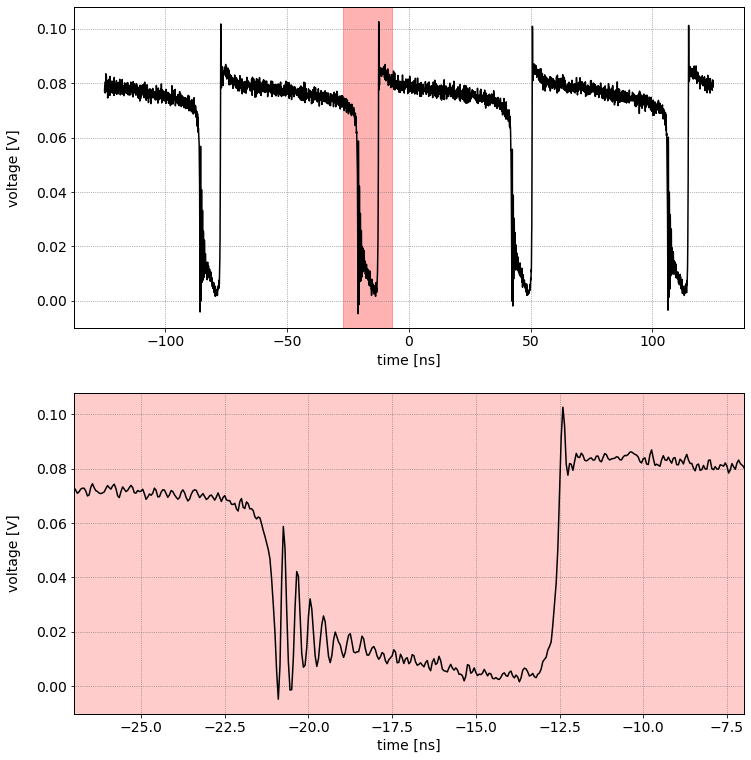

In [52]:
# plot sustained oscillation trace to check

trace_ind = 4

name_list = ['sustained_osc_Vrb0_agilent_ch3_P_trans_fast',
            'sustained_osc_Vrb1_agilent_ch3_P_trans_fast',
            'sustained_osc_Vrb2_agilent_ch3_P_trans_fast',
            'sustained_osc_Pf100mW_Vrb0_agilent_ch3_P_trans_fast',
            'sustained_osc_Pf100mW_Vrb1_agilent_ch3_P_trans_fast',
            'sustained_osc_Pf100mW_Vrb2_agilent_ch3_P_trans_fast',
            'sustained_osc_Pf200mW_Vrb0_agilent_ch3_P_trans_fast',
            'sustained_osc_Pf200mW_Vrb1_agilent_ch3_P_trans_fast',
            'sustained_osc_Pf200mW_Vrb2_agilent_ch3_P_trans_fast']
x_zoom_center_list = [14.5,14.5,14.5,0,-17,-17,15,25,4,]
x_zoom_width = 20
#x_zoom0_list = [0,7,7,-10,-25,7,7,7,7]
#x_zoom1_list = [50,22,22,10,-5,22,22,22,22]

t_load,V_load = load_agilent_trace(name=name_list[trace_ind])

# plot agilent scope test data 
data_skip0 = 10 #1
data_skip1 = 1
fig = plt.figure(figsize=(12,13))
gs = GridSpec(2,1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
trace_len = len(t_load)
zoom_len0 = 5000#30000 
zoom_len1 = 4000#900
#zoom_offset = 18 * u.ns
t_plot0 = t_load[int(trace_len/2-zoom_len0/2):int(trace_len/2+zoom_len0/2)].to(u.ns) - t_load[int(trace_len/2)].to(u.ns)
t_plot1 = t_load[int(trace_len/2-zoom_len1/2):int(trace_len/2+zoom_len1/2)].to(u.ns) - t_load[int(trace_len/2)].to(u.ns)

V_plot0 = V_load[int(trace_len/2-zoom_len0/2):int(trace_len/2+zoom_len0/2)]
V_plot1 = V_load[int(trace_len/2-zoom_len1/2):int(trace_len/2+zoom_len1/2)]
ax0.plot(t_plot0,V_plot0,color='k',label='ch3 zoom data')
ax1.plot(t_plot1,V_plot1,color='k',label='ch3 zoom data')
#ax0.plot(t3_load[::data_skip].to(u.us),V3_load[::data_skip],color='C3',label='ch3 test data')
#del t_load
#del V_load
#ax0.set_xlim([0,28])
x_zoom0 = x_zoom_center_list[trace_ind] - x_zoom_width / 2.0
x_zoom1 = x_zoom_center_list[trace_ind] + x_zoom_width / 2.0
ax0.axvspan(x_zoom0, x_zoom1, alpha=0.3, color='red')
ax1.set_xlim([x_zoom0,x_zoom1])
ax1.axvspan(x_zoom0, x_zoom1, alpha=0.2, color='red')

#ax0.legend()
ax0.set_ylabel('voltage [V]',labelpad=15)
ax1.set_ylabel('voltage [V]',labelpad=15)
ax0.set_xlabel('time [ns]')
ax1.set_xlabel('time [ns]')


trace_len: 1001669.0


Text(0.5, 0, 'time [ns]')

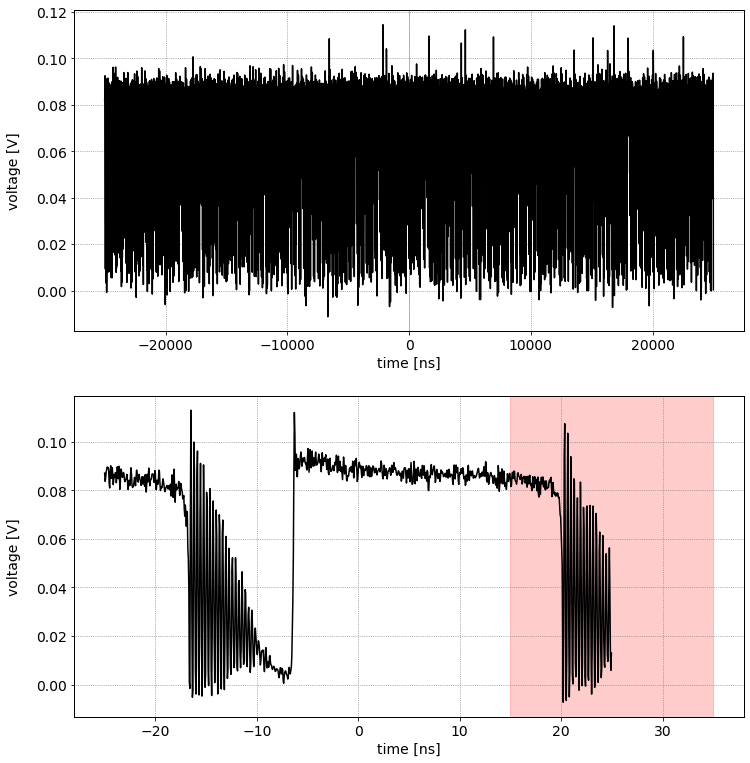

In [171]:
# plot larger zoom range
trace_ind = 7
t_load,V_load = load_agilent_trace(name=name_list[trace_ind])

# plot agilent scope test data 
data_skip0 = 300 #1
data_skip1 = 1
fig = plt.figure(figsize=(12,13))
gs = GridSpec(2,1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
trace_len = len(t_load)
printval(trace_len)
zoom_len0 = 1000000
zoom_len1 = 1000#900
#zoom_offset = 18 * u.ns
t_plot0 = t_load[int(trace_len/2-zoom_len0/2):int(trace_len/2+zoom_len0/2)].to(u.ns) - t_load[int(trace_len/2)].to(u.ns)
t_plot1 = t_load[int(trace_len/2-zoom_len1/2):int(trace_len/2+zoom_len1/2)].to(u.ns) - t_load[int(trace_len/2)].to(u.ns)

V_plot0 = V_load[int(trace_len/2-zoom_len0/2):int(trace_len/2+zoom_len0/2)]
V_plot1 = V_load[int(trace_len/2-zoom_len1/2):int(trace_len/2+zoom_len1/2)]
ax0.plot(t_plot0[::data_skip0],V_plot0[::data_skip0],color='k',label='ch3 zoom data')
ax1.plot(t_plot1[::data_skip1],V_plot1[::data_skip1],color='k',label='ch3 zoom data')
#ax0.plot(t3_load[::data_skip].to(u.us),V3_load[::data_skip],color='C3',label='ch3 test data')
del t_load
del V_load
#ax0.set_xlim([0,28])
x_zoom0 = x_zoom_center_list[trace_ind] - x_zoom_width / 2.0
x_zoom1 = x_zoom_center_list[trace_ind] + x_zoom_width / 2.0
ax0.axvspan(x_zoom0, x_zoom1, alpha=0.3, color='red')
#ax1.set_xlim([x_zoom0,x_zoom1])
ax1.axvspan(x_zoom0, x_zoom1, alpha=0.2, color='red')

#ax0.legend()
ax0.set_ylabel('voltage [V]',labelpad=15)
ax1.set_ylabel('voltage [V]',labelpad=15)
ax0.set_xlabel('time [ns]')
ax1.set_xlabel('time [ns]')


## FFTs

In [11]:
# load sustained oscillation traces and calculate spectra
fnames =    [
    'sustained_osc_Vrb0_agilent_ch3_P_trans_fast',
    'sustained_osc_Vrb1_agilent_ch3_P_trans_fast',
    'sustained_osc_Vrb2_agilent_ch3_P_trans_fast',
    'sustained_osc_Pf100mW_Vrb0_agilent_ch3_P_trans_fast',
    'sustained_osc_Pf100mW_Vrb1_agilent_ch3_P_trans_fast',
    'sustained_osc_Pf100mW_Vrb2_agilent_ch3_P_trans_fast',
    'sustained_osc_Pf200mW_Vrb0_agilent_ch3_P_trans_fast',
    'sustained_osc_Pf200mW_Vrb1_agilent_ch3_P_trans_fast',
    'sustained_osc_Pf200mW_Vrb2_agilent_ch3_P_trans_fast',
    ]

fs = [0 for name in fnames]
PSDs = [0 for name in fnames]

for find,name in enumerate(fnames):
    t_load,V_load = load_agilent_trace(name=fnames[find],)
    #compute approximate PSD
    f_samp = ( 1 / (t_load[1]-t_load[0])).to(u.Hz).m
    f, Pxx_den = signal.periodogram(V_load, f_samp)
    #PSD_norm = Pxx_den / Pxx_den.max()
    fs[find] = f
    PSDs[find] = Pxx_den
    del t_load,V_load,f,Pxx_den



<IPython.core.display.Javascript object>


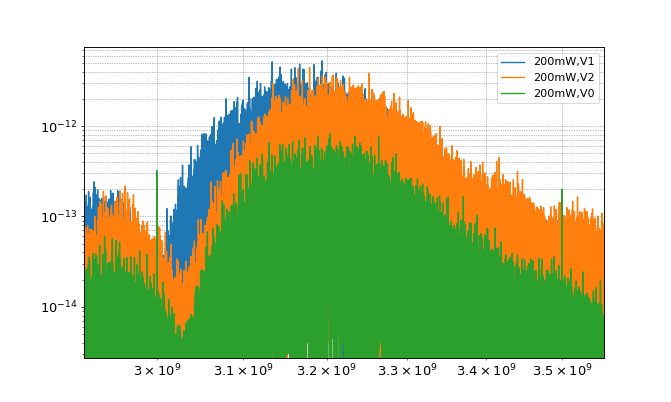

In [15]:
# plot sustained oscillation trace spectra
fig = plt.figure()
ax = fig.add_subplot(111)

labels =    [
    '50mW,V0',
    '50mW,V1',
    '50mW,V2',
    '100mW,V0',
    '100mW,V1',
    '100mW,V2',
    '200mW,V0',
    '200mW,V1',
    '200mW,V2',
    ]

inds = [7,8,6]
for ind in inds:
    ax.loglog(fs[ind],PSDs[ind],label=labels[ind])

ax.set_xlim([1e6,1e10])
ax.set_ylim([1e-16,1e-9])
#ax.grid()
ax.legend()
#ax.set_ylabel('voltage [V]',labelpad=35)
#ax.set_xlabel('time [ns]')


<IPython.core.display.Javascript object>


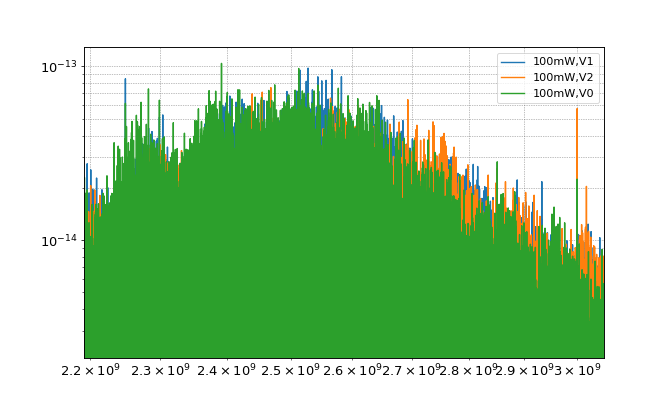

In [16]:
# plot sustained oscillation trace spectra
fig = plt.figure()
ax = fig.add_subplot(111)

labels =    [
    '50mW,V0',
    '50mW,V1',
    '50mW,V2',
    '100mW,V0',
    '100mW,V1',
    '100mW,V2',
    '200mW,V0',
    '200mW,V1',
    '200mW,V2',
    ]

inds = [4,5,3]
for ind in inds:
    ax.loglog(fs[ind],PSDs[ind],label=labels[ind])

ax.set_xlim([1e6,1e10])
ax.set_ylim([1e-16,1e-9])
#ax.grid()
ax.legend()
#ax.set_ylabel('voltage [V]',labelpad=35)
#ax.set_xlabel('time [ns]')


<IPython.core.display.Javascript object>


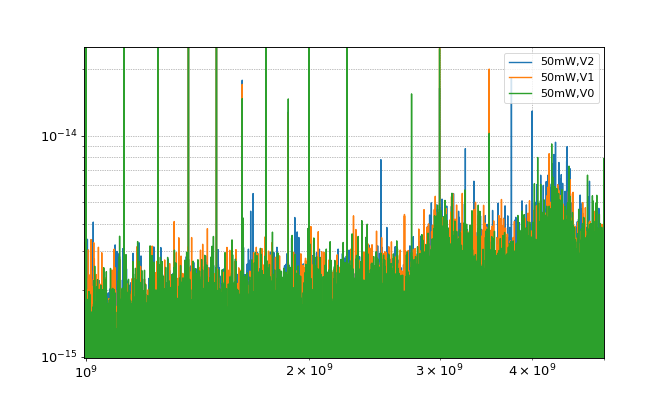

In [17]:
# plot sustained oscillation trace spectra
fig = plt.figure()
ax = fig.add_subplot(111)

labels =    [
    '50mW,V0',
    '50mW,V1',
    '50mW,V2',
    '100mW,V0',
    '100mW,V1',
    '100mW,V2',
    '200mW,V0',
    '200mW,V1',
    '200mW,V2',
    ]

inds = [2,1,0]
for ind in inds:
    ax.loglog(fs[ind],PSDs[ind],label=labels[ind])

ax.set_xlim([1e6,1e10])
ax.set_ylim([1e-16,1e-9])
#ax.grid()
ax.legend()
#ax.set_ylabel('voltage [V]',labelpad=35)
#ax.set_xlabel('time [ns]')


# long FCO traces

In [3]:
# fnames = [ 'Agilent_54855A_scope_trace_long_fco_dev3_short_circuit_blue_to_red_1_2018_06_26_12_40_20.hdf5',
# 'Agilent_54855A_scope_trace_long_fco_dev3_short_circuit_blue_to_red_2_2018_06_26_21_26_04.hdf5',
#  'Agilent_54855A_scope_trace_long_fco_dev3_short_circuit_blue_to_red_3_2018_06_26_22_41_41.hdf5',
#          ]
fnames = [ 'long_fco_dev3_short_circuit_blue_to_red_1',
'long_fco_dev3_short_circuit_blue_to_red_2',
 'long_fco_dev3_short_circuit_blue_to_red_3',
         ]



### trace 2

In [4]:
# configure plot of long FCO trace 2 with zooms
trace_ind = 2
tlim0 = -25,25
tlim10 = -20.,-19.2
tlim11 = -0.01,0.01
tlim12 = 15.,15.3
data_skip0 = 100 
data_skip10 = 1 #10
data_skip11 = 1
data_skip12 = 10

t_load,V_load = load_agilent_trace(name=fnames[trace_ind])
t_load = t_load.to(u.us)
trace_len = len(t_load)
t_min = t_load.min()
t_max = t_load.max()
printval(trace_len)
printval(t_min)
printval(t_max)

t0 = t_load[::data_skip0]
t10 = t_load[::data_skip10]
t11 = t_load[::data_skip11]
t12 = t_load[::data_skip12]

# del t_load

t_mask0 = (t0.m>tlim0[0])*(t0.m<tlim0[1])
t_mask10 = (t10.m>tlim10[0])*(t10.m<tlim10[1])
t_mask11 = (t11.m>tlim11[0])*(t11.m<tlim11[1])
t_mask12 = (t12.m>tlim12[0])*(t12.m<tlim12[1])

x0 = t0[t_mask0].m
x10 = t10.to(u.us)[t_mask10].m
x11 = t11.to(u.ns)[t_mask11].m
x12 = t12.to(u.us)[t_mask12].m

y0 = V_load[::data_skip0][t_mask0]
y10 = V_load[::data_skip10][t_mask10]
y11 = V_load[::data_skip11][t_mask11]
y12 = V_load[::data_skip12][t_mask12]

# del V_load

trace_len: 1001669.0
t_min: -25.0 microsecond
t_max: 25.0 microsecond


/home/dodd/.local/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


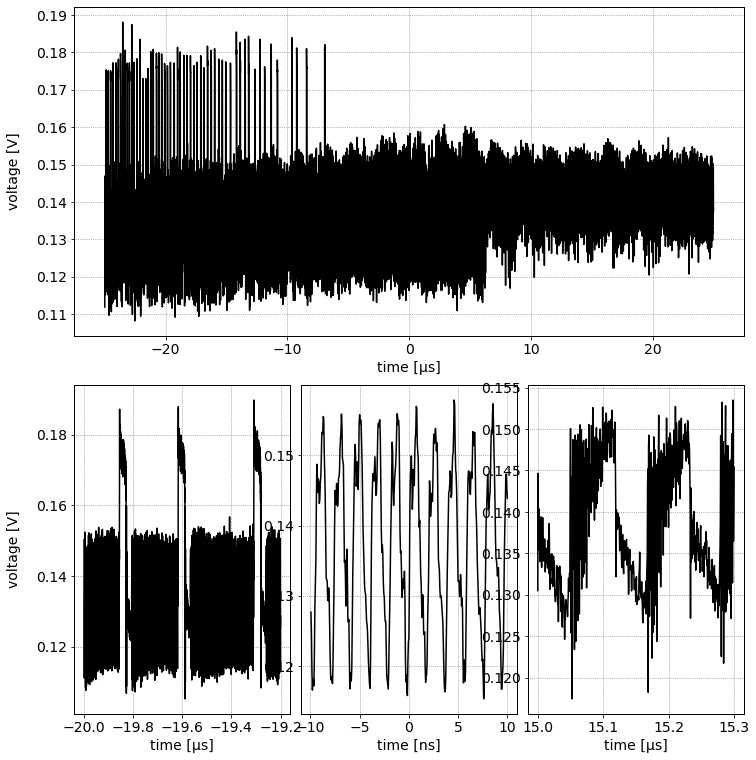

In [5]:
# plot long FCO trace 2 with zooms
fig = plt.figure(figsize=(12,13))
gs = GridSpec(2,
              3,
              height_ratios=[1,1],
              hspace=0.15,
              width_ratios=[1,1,1],
              wspace=0.05,
             )
ax0 = fig.add_subplot(gs[0,:])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])

ax0.plot(x0,y0,color='k',)
ax10.plot(x10,y10,color='k',)
ax11.plot(x11,y11,color='k',)
ax12.plot(x12,y12,color='k',)
# ax10.plot(x10-x10[0],y10,color='k',)
# ax11.plot(x11-x11[0],y11,color='k',)
# ax12.plot(x12-x12[0],y12,color='k',)

ax0.set_ylabel('voltage [V]',labelpad=15)
ax10.set_ylabel('voltage [V]',labelpad=15)
for a in [ax0,ax10,ax12]:
    a.set_xlabel('time [μs]')
for a in [ax11]:
    a.set_xlabel('time [ns]')


<IPython.core.display.Javascript object>


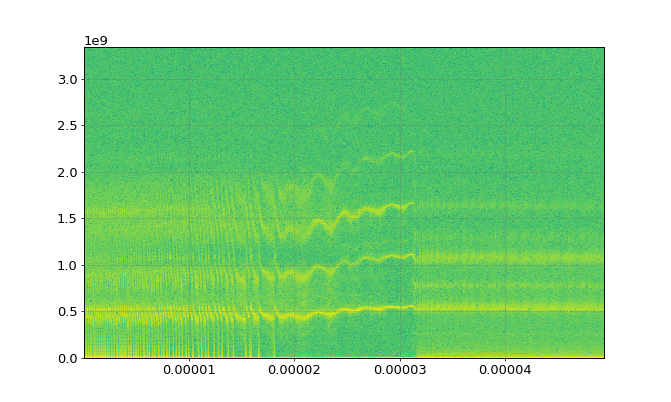

In [30]:

n_oversample = 1
NFFT = 2**12
noverlap = 2**11
cmap = cm.viridis


t_new = np.linspace(t_load.m.min(),t_load.m.max(),n_oversample*len(t_load)-1)
x_new = np.interp(t_new,t_load.m,V_load.m,)
f_samp = ( n_oversample / (t_load[1]-t_load[0])).to(u.Hz).m

fig,ax = plt.subplots(1,1)
sg = ax.specgram(x_new,
                 NFFT=NFFT,
                 Fs=f_samp,
                 window=None,
                 noverlap=noverlap,
                 cmap=cmap,
                 scale='dB',
                 vmax=-105,
                ) 

In [6]:
import matplotlib.mlab as mlab

n_oversample = 1
NFFT = 2**14
noverlap = 2**13
cmap = cm.viridis


t_new = np.linspace(t_load.m.min(),t_load.m.max(),n_oversample*len(t_load)-1)
x_new = np.interp(t_new,t_load.m,V_load.m,)
f_samp = ( n_oversample / (t_load[1]-t_load[0])).to(u.Hz).m
Pxx,freq,t = mlab.specgram(x_new,
                 NFFT=NFFT,
                 Fs=f_samp,
                 window=None,
                 noverlap=noverlap,
                ) 

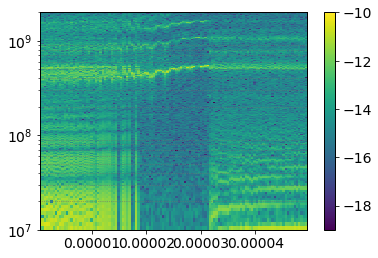

In [10]:
%matplotlib inline
fig,ax = plt.subplots(1,1)

p = ax.pcolor(t,
              freq,
              np.log10(Pxx),
              vmax=-10,
              vmin=-19,
              cmap=cm.viridis,
             )
ax.set_yscale('log')
ax.set_ylim(1e7,2e9)
plt.colorbar(p)

In [136]:
# configure plot of center region of long FCO trace 2 with zooms
trace_ind = 2
tlim0 = -8,8
tlim10 = -8.,-7.98
tlim11 = -.01,.01
tlim12 = 5,5.02 #6,6.02
data_skip0 = 100 
data_skip10 = 1 #10
data_skip11 = 1
data_skip12 = 1

t_load,V_load = load_agilent_trace(name=fnames[trace_ind])
t_load = t_load.to(u.us)
trace_len = len(t_load)
t_min = t_load.min()
t_max = t_load.max()
printval(trace_len)
printval(t_min)
printval(t_max)

t0 = t_load[::data_skip0]
t10 = t_load[::data_skip10]
t11 = t_load[::data_skip11]
t12 = t_load[::data_skip12]

del t_load

t_mask0 = (t0.m>tlim0[0])*(t0.m<tlim0[1])
t_mask10 = (t10.m>tlim10[0])*(t10.m<tlim10[1])
t_mask11 = (t11.m>tlim11[0])*(t11.m<tlim11[1])
t_mask12 = (t12.m>tlim12[0])*(t12.m<tlim12[1])

x0 = t0[t_mask0].m
x10 = t10.to(u.us)[t_mask10].m
x11 = t11.to(u.ns)[t_mask11].m
x12 = t12.to(u.us)[t_mask12].m

y0 = V_load[::data_skip0][t_mask0]
y10 = V_load[::data_skip10][t_mask10]
y11 = V_load[::data_skip11][t_mask11]
y12 = V_load[::data_skip12][t_mask12]

del V_load



trace_len: 1001669.0
t_min: -25.0 microsecond
t_max: 25.0 microsecond


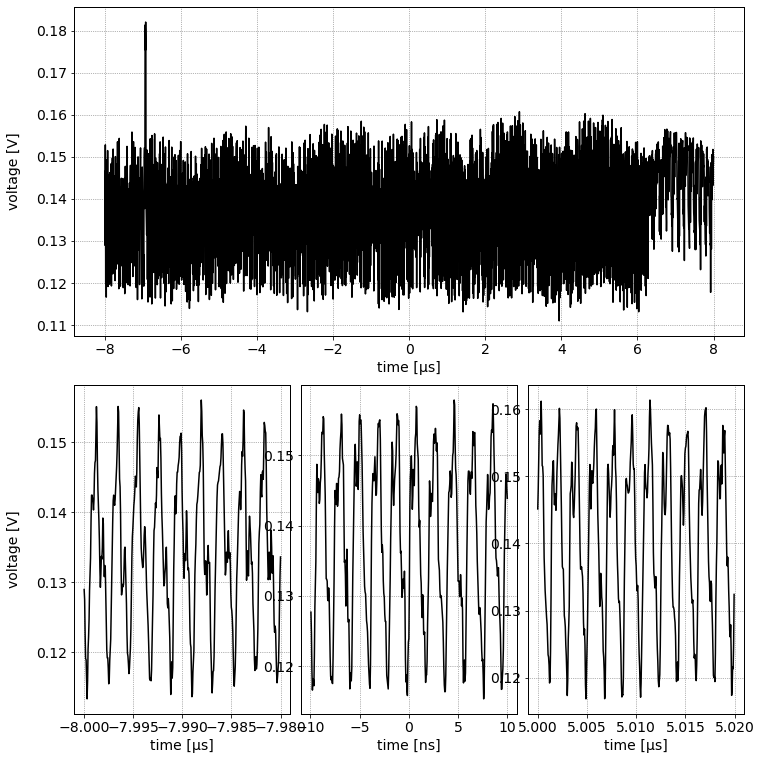

In [137]:
# plot long FCO trace 2 with zooms
fig = plt.figure(figsize=(12,13))
gs = GridSpec(2,
              3,
              height_ratios=[1,1],
              hspace=0.15,
              width_ratios=[1,1,1],
              wspace=0.05,
             )
ax0 = fig.add_subplot(gs[0,:])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])

ax0.plot(x0,y0,color='k',)
ax10.plot(x10,y10,color='k',)
ax11.plot(x11,y11,color='k',)
ax12.plot(x12,y12,color='k',)
# ax10.plot(x10-x10[0],y10,color='k',)
# ax11.plot(x11-x11[0],y11,color='k',)
# ax12.plot(x12-x12[0],y12,color='k',)

ax0.set_ylabel('voltage [V]',labelpad=15)
ax10.set_ylabel('voltage [V]',labelpad=15)
for a in [ax0,ax10,ax12]:
    a.set_xlabel('time [μs]')
for a in [ax11]:
    a.set_xlabel('time [ns]')


In [144]:
# configure plot of long FCO trace 2 with zooms
trace_ind = 2
tlim0 = -11,7
tlim10 = -10.5,-10.2
tlim11 = -0.01,0.01
tlim12 = 5.,5.3
data_skip0 = 100 
data_skip10 = 1 #10
data_skip11 = 1
data_skip12 = 10

t_load,V_load = load_agilent_trace(name=fnames[trace_ind])
t_load = t_load.to(u.us)
trace_len = len(t_load)
t_min = t_load.min()
t_max = t_load.max()
printval(trace_len)
printval(t_min)
printval(t_max)

t0 = t_load[::data_skip0]
t10 = t_load[::data_skip10]
t11 = t_load[::data_skip11]
t12 = t_load[::data_skip12]

del t_load

t_mask0 = (t0.m>tlim0[0])*(t0.m<tlim0[1])
t_mask10 = (t10.m>tlim10[0])*(t10.m<tlim10[1])
t_mask11 = (t11.m>tlim11[0])*(t11.m<tlim11[1])
t_mask12 = (t12.m>tlim12[0])*(t12.m<tlim12[1])

x0 = t0[t_mask0].m
x10 = t10.to(u.us)[t_mask10].m
x11 = t11.to(u.ns)[t_mask11].m
x12 = t12.to(u.us)[t_mask12].m

y0 = V_load[::data_skip0][t_mask0]
y10 = V_load[::data_skip10][t_mask10]
y11 = V_load[::data_skip11][t_mask11]
y12 = V_load[::data_skip12][t_mask12]

del V_load

trace_len: 1001669.0
t_min: -25.0 microsecond
t_max: 25.0 microsecond


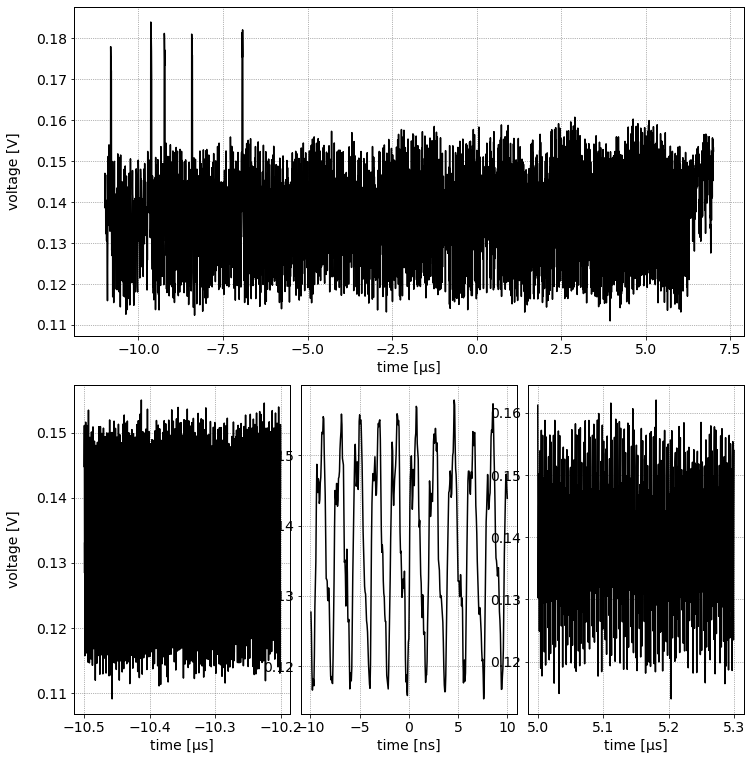

In [145]:
# plot long FCO trace 2 with zooms
fig = plt.figure(figsize=(12,13))
gs = GridSpec(2,
              3,
              height_ratios=[1,1],
              hspace=0.15,
              width_ratios=[1,1,1],
              wspace=0.05,
             )
ax0 = fig.add_subplot(gs[0,:])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])

ax0.plot(x0,y0,color='k',)
ax10.plot(x10,y10,color='k',)
ax11.plot(x11,y11,color='k',)
ax12.plot(x12,y12,color='k',)
# ax10.plot(x10-x10[0],y10,color='k',)
# ax11.plot(x11-x11[0],y11,color='k',)
# ax12.plot(x12-x12[0],y12,color='k',)

ax0.set_ylabel('voltage [V]',labelpad=15)
ax10.set_ylabel('voltage [V]',labelpad=15)
for a in [ax0,ax10,ax12]:
    a.set_xlabel('time [μs]')
for a in [ax11]:
    a.set_xlabel('time [ns]')


### trace 1

In [138]:
# configure plot of long FCO trace 1 with zooms
trace_ind = 1
tlim0 = -25,25
tlim10 = -20.,-19.2
tlim11 = -0.01,0.01
tlim12 = 15.,15.3
data_skip0 = 100 
data_skip10 = 1 #10
data_skip11 = 1
data_skip12 = 10

t_load,V_load = load_agilent_trace(name=fnames[trace_ind])
t_load = t_load.to(u.us)
trace_len = len(t_load)
t_min = t_load.min()
t_max = t_load.max()
printval(trace_len)
printval(t_min)
printval(t_max)

t0 = t_load[::data_skip0]
t10 = t_load[::data_skip10]
t11 = t_load[::data_skip11]
t12 = t_load[::data_skip12]

del t_load

t_mask0 = (t0.m>tlim0[0])*(t0.m<tlim0[1])
t_mask10 = (t10.m>tlim10[0])*(t10.m<tlim10[1])
t_mask11 = (t11.m>tlim11[0])*(t11.m<tlim11[1])
t_mask12 = (t12.m>tlim12[0])*(t12.m<tlim12[1])

x0 = t0[t_mask0].m
x10 = t10.to(u.us)[t_mask10].m
x11 = t11.to(u.ns)[t_mask11].m
x12 = t12.to(u.us)[t_mask12].m

y0 = V_load[::data_skip0][t_mask0]
y10 = V_load[::data_skip10][t_mask10]
y11 = V_load[::data_skip11][t_mask11]
y12 = V_load[::data_skip12][t_mask12]

del V_load

trace_len: 400669.0
t_min: -10.0 microsecond
t_max: 10.0 microsecond


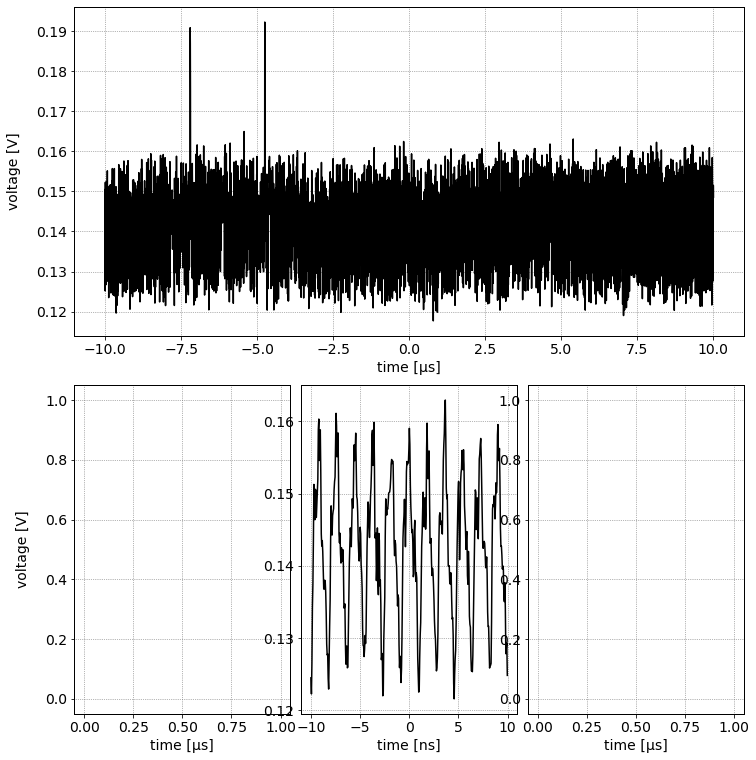

In [139]:
# plot long FCO trace 1 with zooms
fig = plt.figure(figsize=(12,13))
gs = GridSpec(2,
              3,
              height_ratios=[1,1],
              hspace=0.15,
              width_ratios=[1,1,1],
              wspace=0.05,
             )
ax0 = fig.add_subplot(gs[0,:])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])

ax0.plot(x0,y0,color='k',)
ax10.plot(x10,y10,color='k',)
ax11.plot(x11,y11,color='k',)
ax12.plot(x12,y12,color='k',)
# ax10.plot(x10-x10[0],y10,color='k',)
# ax11.plot(x11-x11[0],y11,color='k',)
# ax12.plot(x12-x12[0],y12,color='k',)

ax0.set_ylabel('voltage [V]',labelpad=15)
ax10.set_ylabel('voltage [V]',labelpad=15)
for a in [ax0,ax10,ax12]:
    a.set_xlabel('time [μs]')
for a in [ax11]:
    a.set_xlabel('time [ns]')


### trace 0

In [142]:
# configure plot of long FCO trace 1 with zooms
trace_ind = 0
tlim0 = -25,25
tlim10 = -20.,-19.2
tlim11 = -0.01,0.01
tlim12 = 15.,15.3
data_skip0 = 10 
data_skip10 = 1 #10
data_skip11 = 1
data_skip12 = 10

t_load,V_load = load_agilent_trace(name=fnames[trace_ind])
t_load = t_load.to(u.us)
trace_len = len(t_load)
t_min = t_load.min()
t_max = t_load.max()
printval(trace_len)
printval(t_min)
printval(t_max)

t0 = t_load[::data_skip0]
t10 = t_load[::data_skip10]
t11 = t_load[::data_skip11]
t12 = t_load[::data_skip12]

del t_load

t_mask0 = (t0.m>tlim0[0])*(t0.m<tlim0[1])
t_mask10 = (t10.m>tlim10[0])*(t10.m<tlim10[1])
t_mask11 = (t11.m>tlim11[0])*(t11.m<tlim11[1])
t_mask12 = (t12.m>tlim12[0])*(t12.m<tlim12[1])

x0 = t0[t_mask0].m
x10 = t10.to(u.us)[t_mask10].m
x11 = t11.to(u.ns)[t_mask11].m
x12 = t12.to(u.us)[t_mask12].m

y0 = V_load[::data_skip0][t_mask0]
y10 = V_load[::data_skip10][t_mask10]
y11 = V_load[::data_skip11][t_mask11]
y12 = V_load[::data_skip12][t_mask12]

del V_load

trace_len: 100169.0
t_min: -2.5 microsecond
t_max: 2.5 microsecond


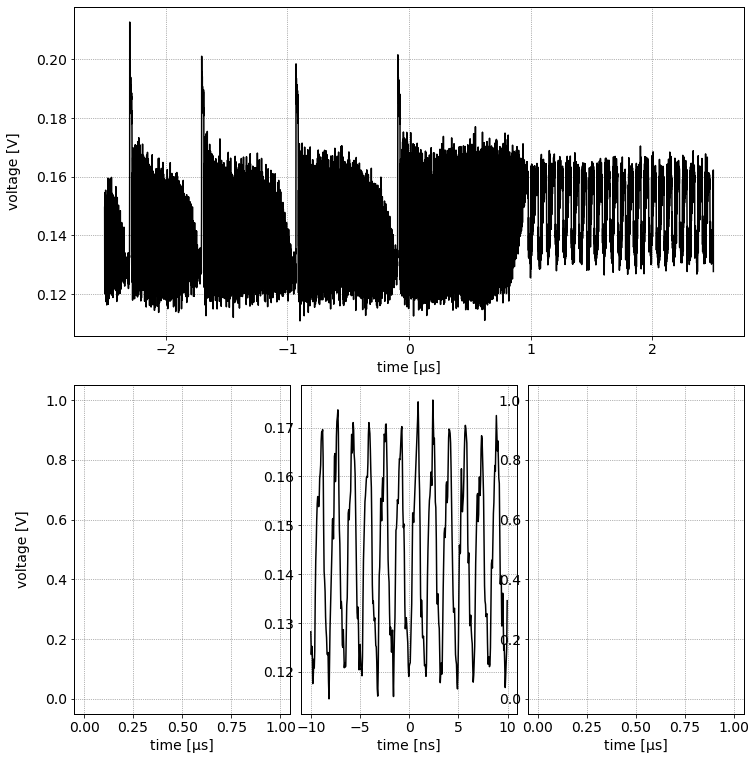

In [143]:
# plot long FCO trace 1 with zooms
fig = plt.figure(figsize=(12,13))
gs = GridSpec(2,
              3,
              height_ratios=[1,1],
              hspace=0.15,
              width_ratios=[1,1,1],
              wspace=0.05,
             )
ax0 = fig.add_subplot(gs[0,:])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])

ax0.plot(x0,y0,color='k',)
ax10.plot(x10,y10,color='k',)
ax11.plot(x11,y11,color='k',)
ax12.plot(x12,y12,color='k',)
# ax10.plot(x10-x10[0],y10,color='k',)
# ax11.plot(x11-x11[0],y11,color='k',)
# ax12.plot(x12-x12[0],y12,color='k',)

ax0.set_ylabel('voltage [V]',labelpad=15)
ax10.set_ylabel('voltage [V]',labelpad=15)
for a in [ax0,ax10,ax12]:
    a.set_xlabel('time [μs]')
for a in [ax11]:
    a.set_xlabel('time [ns]')

# Vrb power sweeps with multistability

In [3]:
# function defs for loading data
scope_data_dir = '/media/dodd/backup/transfer from Stanford/agilent_scope_data'

def load_scope_trace(name='',data_dir=scope_data_dir,latest_file=True,verbose=False):
    tia_gain=False
    voltage_gain=False
    if latest_file:
        last_word = name.split('_')[-1]
        if (last_word=='TIAsens') or (last_word=='Vgain'):
            file_list =  glob(path.normpath(data_dir)+path.normpath('/Tektronix_MSO_scope_trace_' + name + '*'))
        else:    
            file_list =  glob(path.normpath(data_dir)+path.normpath('/Tektronix_MSO_scope_trace_' + name + '_*'))
        latest_file = max(file_list,key=path.getctime)
        if verbose:
            print_statusline('Loading ' + name +' trace from file: ' + path.basename(path.normpath(latest_file)))
        data = np.load(latest_file)
        if (last_word=='TIAsens'):
            tia_gain = float(latest_file.split(name)[1].split('AperV')[0]) * u.ampere / u.volt
        if (last_word=='Vgain'):
            voltage_gain = float(latest_file.split(name)[1].split('_')[0])  
    else:
        fpath = path.normpath(path.join(data_dir,name))
        if verbose:
            print_statusline('Loading ' + name +' trace from file: ' + path.basename(fpath))
        data = np.load(fpath)
    t = data[:,0] * u.second
    V = data[:,1] * u.volt
    if voltage_gain:
        V = V/voltage_gain
    if tia_gain:
        V = (V*tia_gain).to(u.mA)
    return t,V

def P_Vrb_sweep_load(V_VCA_list,Vrb_list,set_name,data_dir=scope_data_dir):
    set_dir = path.normpath(path.join(data_dir,set_name))
    # first find length of traces by loading first trace from the first Vrb value
    Vrb0 = Vrb_list[0]
    Vvca0 = V_VCA_list[0]
    t,P_ref_V0 = load_scope_trace(name='Vrb{:1.2f}_Vvca{:1.3f}_ch2_P_ref'.format(Vrb0.m,Vvca0.m),data_dir=set_dir)
    # create arrays to hold loaded data
    L = len(P_ref_V0)
    V_P_T = np.zeros((L,len(V_VCA_list),len(Vrb_list)))*u.volt
    V_P_ref = np.zeros((L,len(V_VCA_list),len(Vrb_list)))*u.volt
    V_mod = np.zeros((L,len(V_VCA_list),len(Vrb_list)))*u.volt
    V_I_TPA = np.zeros((L,len(V_VCA_list),len(Vrb_list))) *u.mA #*u.volt
    # load data into newly created arrays
    for Vind, VV in enumerate(Vrb_list):
        for Pind, PP in enumerate(V_VCA_list):
            try:
                t,V_P_T[:,Pind,Vind] =load_scope_trace(name='Vrb{:1.2f}_Vvca{:1.3f}_Vgain'.format(VV.m,PP.m),data_dir=set_dir)
                t,V_P_ref[:,Pind,Vind] = load_scope_trace(name='Vrb{:1.2f}_Vvca{:1.3f}_ch2_P_ref'.format(VV.m,PP.m),data_dir=set_dir)
                t,V_mod[:,Pind,Vind] = load_scope_trace(name='Vrb{:1.2f}_Vvca{:1.3f}_ch3_Vmod'.format(VV.m,PP.m),data_dir=set_dir)
                t,V_I_TPA[:,Pind,Vind] = load_scope_trace(name='Vrb{:1.2f}_Vvca{:1.3f}_TIAsens'.format(VV.m,PP.m),data_dir=set_dir)
            except:
                pass
            
    return {'Vrb_list':Vrb_list,'t':t,'V_P_T':V_P_T,'V_P_ref':V_P_ref,'V_mod':V_mod,'V_I_TPA':V_I_TPA,}



In [4]:
# function def for calculation of P_circ from I_TPA
r = 0.19
γ = 3.1e-9 * u.cm / u.watt
β = 2 * r * γ # 1.178×10-9 centimeter/watt

def I_TPA_to_P_circ(I_TPA,A=0.1*u.um**2,d=40*u.um,lm=1550*u.nm,β=1.18e-9*u.cm/u.watt,verbose=False):
    E_ph = lm.to(u.joule,'sp')
    circumfrence = np.pi * d
    V = A * circumfrence
    P_circ = (A * np.sqrt( ( I_TPA * 2 * E_ph ) / ( β * V * u.elementary_charge ) )).to(u.watt)
    if verbose:
        print('E_ph: {:2.3g} J'.format(E_ph.m))
        print('P_circ: {:2.3g} W'.format(P_circ.m))
    return P_circ

I_TPA_to_P_circ(100*u.uA)

0.10386910352248291 <Unit('watt')>

In [5]:
# load data

# dh0
V_VCA_highVrb_ds0 = np.linspace(1.5,5,36)*u.volt
Vrb_highVrb_ds0 = np.linspace(0,20,41)*u.volt
set_name='highVrb_ds0'
dh0 = P_Vrb_sweep_load(V_VCA_highVrb_ds0,Vrb_highVrb_ds0,set_name)

# dh1
set_name='highVrb_ds1'
V_VCA_highVrb_ds1 = np.linspace(1.5,4.3,10)*u.volt
Vrb_highVrb_ds1 = np.linspace(0,20,10)*u.volt
dh1 = P_Vrb_sweep_load(V_VCA_highVrb_ds1,Vrb_highVrb_ds1,set_name)

# dh2
set_name='highVrb_ds2'
V_VCA_highVrb_ds2 = np.linspace(1.4,4.3,20)*u.volt
Vrb_highVrb_ds2 = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,7.5,10,12.5,15,17.5,20])*u.volt
dh2 = P_Vrb_sweep_load(V_VCA_highVrb_ds2,Vrb_highVrb_ds2,set_name)

# dl0
set_name='lowVrb_ds0'
V_VCA_lowVrb_ds0 = np.linspace(1.5,5,10)*u.volt
Vrb_lowVrb_ds0 = np.linspace(0,5,10)*u.volt
dl0 = P_Vrb_sweep_load(V_VCA_lowVrb_ds0,Vrb_lowVrb_ds0,set_name)

/home/dodd/.local/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


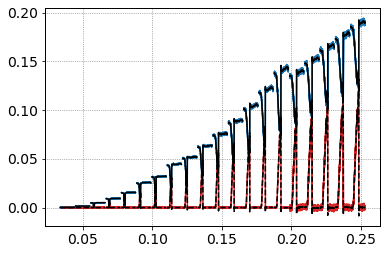

In [6]:
d = dh2
Vrb_ind = 0
Pind = 1
data_skip = 3
t = dh2['t']
tlim = 0.034,0.044
tlim_offset = 0.033,0.034
xoffset = 0.011*u.second
#tlim = 0.0078,0.0095
#tlim = t.min(),t.max()
t_mask = (t.m>tlim[0])*(t.m<tlim[1])
t_mask_offset = (t.m>tlim_offset[0])*(t.m<tlim_offset[1])
x = t[t_mask]
from scipy import signal
b, a = signal.butter(4, 0.02)



fig,ax = plt.subplots(1,1)
# axt = ax.twinx()
# for Pind in range(10):
#     x = t[t_mask][::data_skip]
#     y0 = dh1['V_P_T'][:,Vrb_ind,Pind][t_mask][::data_skip]
#     y1 = dh1['V_I_TPA'][:,Vrb_ind,Pind][t_mask][::data_skip]
#     ax.plot(x+Pind*xoffset,y0)
#     axt.plot(x+Pind*xoffset,y1,'C3')
    
# for Pind in range(10):
#     x = t[t_mask][::data_skip]
#     y0 = dh2['V_P_T'][:,Pind,Vrb_ind][t_mask][::data_skip]
#     y1 = dh2['V_I_TPA'][:,Pind,Vrb_ind][t_mask][::data_skip]
#     ax.plot(x+Pind*xoffset,y0)
#     axt.plot(x+Pind*xoffset,y1,)

dh2['V_P_T_norm'] = np.zeros((len(x),20,3))

for Pind in range(20):
    y0 = dh2['V_P_T'][:,Pind,Vrb_ind][t_mask]
    y1 = dh2['V_I_TPA'][:,Pind,Vrb_ind][t_mask]
    y0_offset = dh2['V_P_T'][:,Pind,Vrb_ind][t_mask_offset].m.mean()*u.volt
    y0_norm = y0 - y0_offset
    y0_norm = y0_norm/(-1*y0_norm.min())
    dh2['V_P_T_norm'][:,Pind,Vrb_ind] = y0_norm
    y0_filt = signal.filtfilt(b, a, y0.m, padlen=50)
    y1_filt = signal.filtfilt(b, a, y1.m, padlen=50)


# x = t[t_mask][::data_skip]
# y0 = dh2['V_P_T'][:,Pind,Vrb_ind][t_mask][::data_skip]
# y1 = dh2['V_I_TPA'][:,Pind,Vrb_ind][t_mask][::data_skip]

    ax.plot(x[::data_skip]+Pind*xoffset,y1[::data_skip],'C3')
    ax.plot(x[::data_skip]+Pind*xoffset,y0[::data_skip],'C0')
    ax.plot(x+Pind*xoffset,y0_filt,'k-',lw=1.5)
    ax.plot(x+Pind*xoffset,y1_filt,'k--',lw=1.5)

peak_inds:
[5692 6994]


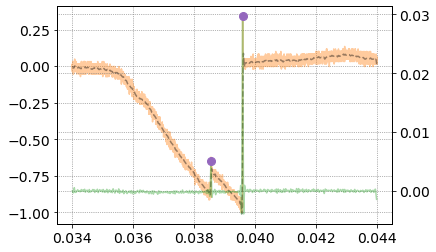

In [79]:
Vrb_ind = 2
Pind = 16
tlim = 0.034,0.044
tlim_offset = 0.033,0.034
filter_cutoff = 0.03 # cutoff frequency of butterworth LP filter applied, in units of per sample
filter_order = 4 # order of butterworth LP filter
peak_min = 0.004 # V/sample change
#tlim = 0.0078,0.0095
#tlim = t.min(),t.max()
t_full = dh2['t']
t_mask = (t_full.m>tlim[0])*(t_full.m<tlim[1])
t_mask_offset = (t_full.m>tlim_offset[0])*(t_full.m<tlim_offset[1])
t = t_full[t_mask]
V_offset = dh2['V_P_T'][t_mask_offset,Pind,Vrb_ind].m.mean()
V = dh2['V_P_T'][t_mask,Pind,Vrb_ind].m - V_offset
V_norm = V / (-V.min())
b, a = signal.butter(filter_order, filter_cutoff)
V_norm_filt = signal.filtfilt(b, a, V_norm, padlen=50)
V_norm_filt_diff = np.diff(V_norm_filt)
peak_inds,peak_heights = signal.find_peaks(V_norm_filt_diff,peak_min)
print("peak_inds:")
print(peak_inds)
fig,ax = plt.subplots(1,1)
axt = ax.twinx()
axt.plot(t[:-1],V_norm_filt_diff,'C2',alpha=0.4)
ax.plot(t,V_norm,'C1',alpha=0.4,)
ax.plot(t,V_norm_filt,'k--',alpha=0.4,)
for peak_ind in peak_inds:
    axt.plot(t[peak_ind],V_norm_filt_diff[peak_ind],'oC4',alpha=1)

In [35]:
d = dh2
Vrb_ind = 3
Pind = 7
tlim = 0.034,0.044
tlim_offset = 0.033,0.034
filter_cutoff = 0.02 # cutoff frequency of butterworth LP filter applied, in units of per sample
filter_order = 4 # order of butterworth LP filter
peak_min = 0.008 # V/sample change
#tlim = 0.0078,0.0095
#tlim = t.min(),t.max()
t_full = d['t']
t_mask = (t_full.m>tlim[0])*(t_full.m<tlim[1])
t_mask_offset = (t_full.m>tlim_offset[0])*(t_full.m<tlim_offset[1])
t = t_full[t_mask]

nP = int(len(d['V_P_T'][0,:,0].m))
nV = 3
jump_inds_br = np.zeros((2,nP,nV),dtype='int') # blue-to-red jump indices
jump_inds_rb = np.zeros((2,nP,nV),dtype='int') # red-to-blue jump indices

for Pind in range(nP):
    for Vrb_ind in range(nV):
        V_offset = d['V_P_T'][t_mask_offset,Pind,Vrb_ind].m.mean()
        V = d['V_P_T'][t_mask,Pind,Vrb_ind].m - V_offset
        V_norm = V / (-V.min())
        b, a = signal.butter(filter_order, filter_cutoff)
        V_norm_filt = signal.filtfilt(b, a, V_norm, padlen=50)
        V_norm_filt_diff = np.diff(V_norm_filt)
        peak_inds,peak_heights = signal.find_peaks(V_norm_filt_diff,peak_min)
        if len(peak_inds)==2:
            jump_inds_br[:,Pind,Vrb_ind] = np.array(peak_inds)

d['jump_inds_br'] = jump_inds_br

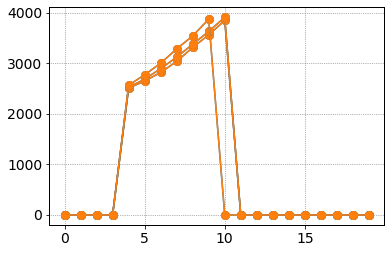

In [36]:
fig,ax = plt.subplots(1,1)

for Vrb_ind,VV in enumerate(d['Vrb_list'][:nV]):
    ax.plot(d['jump_inds_br'][0,:,Vrb_ind],'o-C0',label=f'j0,V{VV:1.1f}')
    ax.plot(d['jump_inds_br'][0,:,Vrb_ind],'o-C1',label=f'j0,V{VV:1.1f}')

In [30]:
d.keys()


dict_keys(['Vrb_list', 't', 'V_P_T', 'V_P_ref', 'V_mod', 'V_I_TPA', 'V_P_T_norm', 'jump_inds_br'])

# ODEInt numerical integration sweeps

In [2]:
import sys
import pickle
nlo_dir = '/home/dodd/github/optics_modeling/NLO_tools'
nld_dir = '/home/dodd/github/optics_modeling/nonlinear_dynamics'
ois_data_dir = '/home/dodd/data/ODEInt_PVDsweep'


for d in [nld_dir]:
    if d not in sys.path:
        sys.path.append(d)

import ODEIntSweep as ois

%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#plt.rcParams.update(rcParamsDefault)
#plt.rcParams.update(my_default_plot_params)
import warnings
warnings.filterwarnings('ignore') # set back to 'default' to see warnings again.

## ds0

In [8]:
# define loading function, add to ODEIntSweep.py later

def load_ODEInt_PVΔ_sweep_trace(Vind,Pind,sweep_name='test',data_dir=ois_data_dir,verbose=True,fpath=None):
    sind = Pind
    if not(fpath):
        file_list =  glob(path.normpath(data_dir)+path.normpath('/ODEInt_PVDsweep_' + sweep_name + '*'))
        set_dir = max(file_list,key=path.getctime)
        b2r_fpath = set_dir + f'/V{Vind}/s{sind}_b2r.dat'
        r2b_fpath = set_dir + f'/V{Vind}/s{sind}_r2b.dat'
    else:
        set_dir = fpath
        b2r_fpath = set_dir + f'/V{Vind}/s{sind}_b2r.dat'
        r2b_fpath = set_dir + f'/V{Vind}/s{sind}_r2b.dat'
    if verbose:
        print('Loading ' + sweep_name +' sweep data from path: ' + path.basename(path.normpath(set_dir)))
    with open( b2r_fpath, "rb" ) as f:
        sol_b2r = pickle.load(f)
    with open( r2b_fpath, "rb" ) as f:
        sol_r2b = pickle.load(f)
    fpath_metadata = path.normpath(set_dir + '/metadata.dat')
    with open( fpath_metadata, "rb" ) as f:
        metadata = pickle.load(f)
    ds_b2r = {'t':sol_b2r.t,
              'Δ':sol_b2r.y[0],
              'a':sol_b2r.y[1],
              'b':sol_b2r.y[3],
              'n':sol_b2r.y[5],
              'T':sol_b2r.y[6],
              'Pa':np.abs(sol_b2r.y[1])**2,
              'Pb':np.abs(sol_b2r.y[3])**2,
            }
    ds_r2b = {'t':sol_r2b.t,
              'Δ':sol_r2b.y[0],
              'a':sol_r2b.y[1],
              'b':sol_r2b.y[3],
              'n':sol_r2b.y[5],
              'T':sol_r2b.y[6],
              'Pa':np.abs(sol_r2b.y[1])**2,
              'Pb':np.abs(sol_r2b.y[3])**2,
            }
    metadata['b2r'] = ds_b2r
    metadata['r2b'] = ds_r2b
    return metadata

# def process_ODEInt_sweep_trace(ds,metadata,Vind,Pind):
    

def load_ODEInt_PVΔ_sweep_metadata(sweep_name='test',data_dir=ois_data_dir,verbose=True,fpath=None):
    if not(fpath):
        file_list =  glob(path.normpath(data_dir)+path.normpath('/ODEInt_PVDsweep_' + sweep_name + '*'))
    latest_metadata_file = max(file_list,key=path.getctime) + '/metadata.dat'
    with open( latest_metadata_file, "rb" ) as f:
        metadata = pickle.load(f)
    return metadata


In [9]:
# load data

# p_si = {
#     'r': 0.189, # nonlinear refraction 2π * n_2 / λ
#     'γ': 3.1e-9 * u.cm/u.watt, # nonlinear refraction 2π * n_2 / λ,
#     'μ': 25, # FCD/FCA ratio
#     'σ': 1.45e-17 * u.cm**2, # FCA cross section (electron-hole average)
#     'c_v': 1./(0.6 * u.degK / u.joule * u.cm**3) # silicon volumetric heat capacity near room temp
# }

# τ_th_list = np.array([30,100,300,1000])*u.ns
# V_rb = np.concatenate((np.arange(0,3,0.5),np.arange(4,24,6)))*u.volt

# p_expt = {
#     'λ': 1.55 * u.um, # free space laser wavelength
#     'FSR': 601 * u.GHz, # measured ring FSR
#     'd_ring': 40 * u.um, # microring diameter
#     'FWHM': 340 * u.MHz, # measured Lorentzian linewidth of single resonance
#     'FWHM_i': 190 * u.MHz, # measured "intrinsic" Lorentzian linewidth of single resonance
#     'splitting': 1.1*u.GHz, # measured double-lorentzian splitting
#     'Δ_min': -35*u.GHz, # f_cavity,0 - f_laser tuning minimum
#     'Δ_max': 10*u.GHz, # f_cavity,0 - f_laser tuning maximum
#     'P_bus_max': 0.4 * u.mW, # max input power in bus waveguide
#     'V_rb': V_rb,
#     'τ_th': 50 * u.ns, # thermal "time constant" to fit
#     'df_dT': -9.7 * u.GHz / u.degK, # measured thermal tuning rate
#     'τ_fc0': 350 * u.ps, # measured/modeled free carrier lifetime at Vrb=0
#     'τ_fc_sat': 3 * u.ps, # measured/modeled minimum free carrier lifetime at Vrb>~15V
#     'V_bi': 1.1 * u.volt, # measured/modeled diode built-in voltage
#     'α_dB': 0.7/u.cm, # fit waveguide loss inside ring in units of dB/cm
#     'A': 0.1 * u.um**2, # mode effective area, from mode solver
#     'β_2': 2 * u.ps**2/u.m, # GVD roughly measured, expected to be ~ 1 ps^2 / m
#     'n_sf': 3, # number of significant figures to leave in the normalized parameters passed to mathematica. the fewer, the faster
#     'δs': 0.4, # s step size (sqrt normalized input power)
#     'δΔ': 0.2,  # Δ step size (cold cavity detuning)
#     'dΔdt': 1e-2,
# }

### ds4

p_si = {
    'r': 0.189, # nonlinear refraction 2π * n_2 / λ
    'γ': 3.1e-9 * u.cm/u.watt, # nonlinear refraction 2π * n_2 / λ,
    'μ': 30, # FCD/FCA ratio
    'σ': 1.45e-17 * u.cm**2, # FCA cross section (electron-hole average)
    'c_v': 1./(0.6 * u.degK / u.joule * u.cm**3), # silicon volumetric heat capacity near room temp
    'μ_e': 1400 * u.cm**2 / u.volt / u.second, # silicon electron mobility near room temp
    'μ_h': 450 * u.cm**2 / u.volt / u.second, # silicon hole mobility near room temp
    'c_v': 1./(0.6 * u.degK / u.joule * u.cm**3), # silicon volumetric heat capacity near room temp
}

# τ_th_list = np.array([30,100,300,1000])*u.ns
τ_th_list = np.array([30])*u.ns
V_rb = np.concatenate((np.arange(0,3,1),np.arange(4,24,6)))*u.volt


p_expt = {
    'λ': 1.55 * u.um, # free space laser wavelength
    'FSR': 601 * u.GHz, # measured ring FSR
    'd_ring': 40 * u.um, # microring diameter
    'FWHM': 350 * u.MHz, # measured Lorentzian linewidth of single resonance
    'FWHM_i': 190 * u.MHz, # measured "intrinsic" Lorentzian linewidth of single resonance
    'splitting': 1.15*u.GHz, # measured double-lorentzian splitting
    'Δ_min': -30*u.GHz, # f_cavity,0 - f_laser tuning minimum
    'Δ_max': 10*u.GHz, # f_cavity,0 - f_laser tuning maximum
    'P_bus_max': 2.0 * u.mW, # max input power in bus waveguide
    'V_rb': V_rb,
    'τ_th': 30 * u.ns, # thermal "time constant" to fit
    'df_dT': -9.7 * u.GHz / u.degK, # measured thermal tuning rate
    'τ_fc0': 150 * u.ps, # measured/modeled free carrier lifetime at Vrb=0
    'τ_fc_sat': 15 * u.ps, # measured/modeled minimum free carrier lifetime at Vrb>~15V
    'V_bi': 0.95 * u.volt, # measured/modeled diode built-in voltage
    'α_dB': 0.7/u.cm, # fit waveguide loss inside ring in units of dB/cm
    'α_abs_dB': 0.0825/u.cm, # based on Gil-Molina+Dainese papers, reporting 0.019/cm (not in dB/cm)
    'A': 0.1 * u.um**2, # mode effective area, from mode solver
    'n_eff': 2.6, # mode effective index from mode solver
    'β_2': 2 * u.ps**2/u.m, # GVD roughly measured, expected to be ~ 1 ps^2 / m
    'n_sf': 2, # number of significant figures to leave in the normalized parameters passed to mathematica. the fewer, the faster
    'δs': 0.4, # s step size (sqrt normalized input power)
    'δΔ': 0.2,  # Δ step size (cold cavity detuning)
    'τ_th_norm_ζ_product': 15.5,  # τ_th_norm * ζ, inferred from experiment data
    'χ3_sw_factor':1.5, # to reflect the effective χ(3) enhancement for standing waves vs. traveling waves = \int_0^\pi (E_{sw} * cos(z))^4 dz, with E_sw = sqrt(2)*E_tr
    'dΔdt': 3e-3,
    'working_precision':20,
}


In [25]:
# d0_t0_path = path.join(ois_data_dir,'ODEInt_PVDsweep_ds0_tau0_2019_12_02_05_34_10')
# d0_t1_path = path.join(ois_data_dir,'ODEInt_PVDsweep_ds0_tau1_2019_12_02_06_21_52')
# d0_t2_path = path.join(ois_data_dir,'ODEInt_PVDsweep_ds0_tau2_2019_12_02_07_09_21')
# d0_t3_path = path.join(ois_data_dir,'ODEInt_PVDsweep_ds0_tau3_2019_12_02_07_56_36')
# d0_t4_path = path.join(ois_data_dir,'ODEInt_PVDsweep_ds4_tau0_2020_01_04_21_46_04')


# load_ODEInt_PVΔ_sweep_metadata(sweep_name='test',data_dir=ois_data_dir,verbose=True,fpath=None)
# ds_path = d0_t4_path
Vind=1
Pind=3

ds4 = load_ODEInt_PVΔ_sweep_trace(Vind,Pind,sweep_name='ds4') #,data_dir=ois_data_dir,verbose=True,fpath=None)

# b2r_fpath = path.join(ds_path,f'V{Vind}/s{sind}_b2r.dat')
# with open(b2r_fpath,'rb') as f:
#     sol_b2r = pickle.load(f)
# t_b2r = sol_b2r.t
# Δ_b2r = sol_b2r.y[0]
# a_b2r = sol_b2r.y[1]
# b_b2r = sol_b2r.y[3]
# Pa_b2r = np.abs(a_b2r)**2
# Pb_b2r = np.abs(b_b2r)**2
# Ptot_b2r = Pa_b2r + Pb_b2r
    
# r2b_fpath = path.join(ds_path,f'V{Vind}/s{sind}_r2b.dat')
# with open(r2b_fpath,'rb') as f:
#     sol_r2b = pickle.load(f)
# t_r2b = sol_r2b.t
# Δ_r2b = sol_r2b.y[0]
# Pa_r2b = np.abs(sol_r2b.y[1])**2
# Pb_r2b = np.abs(sol_r2b.y[3])**2
# Ptot_r2b = Pa_r2b + Pb_r2b

Loading ds4 sweep data from path: ODEInt_PVDsweep_ds4_tau0_2020_01_04_21_46_04


<IPython.core.display.Javascript object>


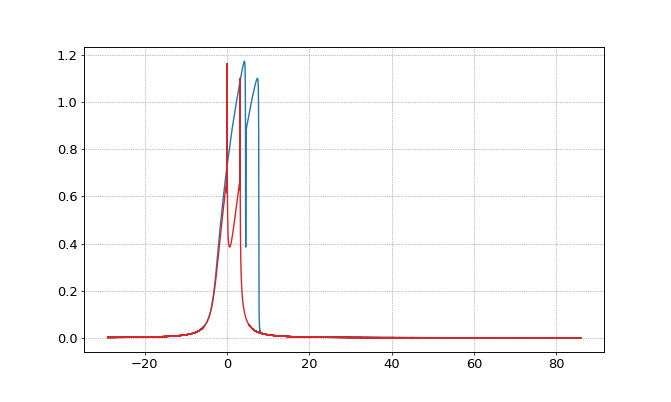

In [11]:
# plot data
d = ds4
fig,ax = plt.subplots(1,1)

colors=['C0','C3']

for ddind,dd in enumerate(['b2r','r2b']):
    ax.plot(-d[dd]['Δ'],d[dd]['Pa']+d[dd]['Pb'],color=colors[ddind])

# ax.plot(-Δ_b2r,Ptot_b2r,'-C0')
# # ax.plot(Δ_b2r,Pa_b2r,':C0')
# # ax.plot(Δ_b2r,Pb_b2r,'--C0')
# ax.plot(-Δ_r2b,Ptot_r2b,'-C3')
# # ax.plot(Δ_r2b,Pa_r2b,':C3')
# # ax.plot(Δ_r2b,Pb_r2b,'--C3')

In [12]:
ds4.keys()
# ds4['b2r'].keys() ## dict_keys(['t', 'Δ', 'a', 'b', 'n', 'T', 'Pa', 'Pb'])

dict_keys(['λ', 'FSR', 'd_ring', 'FWHM', 'FWHM_i', 'splitting', 'Δ_min', 'Δ_max', 'P_bus_max', 'V_rb', 'τ_th', 'df_dT', 'τ_fc0', 'τ_fc_sat', 'V_bi', 'α_dB', 'α_abs_dB', 'A', 'n_eff', 'β_2', 'n_sf', 'δs', 'δΔ', 'τ_th_norm_ζ_product', 'χ3_sw_factor', 'dΔdt', 'working_precision', 'r', 'γ', 'μ', 'σ', 'c_v', 'μ_e', 'μ_h', 'nV', 't_start', 't_stop', 't_elapsed_sec', 'V_params_list', 'b2r', 'r2b'])

In [60]:
n_proc = 32
nP = 6
nV = 7

time = (ds4['t_elapsed_sec']*u.second).to(u.min)
n_step_b2r = len(ds4['b2r']['t'])
n_step_r2b = len(ds4['r2b']['t'])
n_steps = n_step_b2r+n_step_r2b
n_intgns = nP * nV
Δ_range = 2 * ds4['b2r']['Δ'].max().real - ds4['b2r']['Δ'].min().real
t_range = 2 * ds4['b2r']['t'].max().real - ds4['b2r']['t'].min().real
dΔdt = ds4['dΔdt']

time_per_sim = time.to(u.min)/( n_intgns / n_proc)
time_per_linewidth = time.to(u.nV: 7
nP: 6
n_proc: 32
n_intgns: 42
n_intgns_per_proc: 1.3125
dΔdt: 0.003
time: 29.9 minute
n_step_b2r: 766436.0
n_step_r2b: 767092.0
time_per_sim: 22.8 minute
time_per_inverse_linewidth: 17.8 millisecond
time_per_linewidth: 9.5 second
time_per_step: 0.9 millisecondsec)/( Δ_range * n_intgns / n_proc)
time_per_inverse_linewidth = time.to(u.msec)/( t_range * n_intgns / n_proc)
time_per_step = time.to(u.msec)/(n_steps * n_intgns / n_proc)

n_intgns_per_proc = n_intgns * 1./n_proc


print(f'nV: {nV}')
print(f'nP: {nP}')
print(f'n_proc: {n_proc}')
print(f'n_intgns: {n_intgns}')
print(f'n_intgns_per_proc: {n_intgns_per_proc}')
printval(dΔdt,form='g',p=5)
printval(time)
printval(n_step_b2r)
printval(n_step_r2b)
printval(time_per_sim)
printval(time_per_inverse_linewidth)
printval(time_per_linewidth)
printval(time_per_step)

nV: 7
nP: 6
n_proc: 32
n_intgns: 42
n_intgns_per_proc: 1.3125
dΔdt: 0.003
time: 29.9 minute
n_step_b2r: 766436.0
n_step_r2b: 767092.0
time_per_sim: 22.8 minute
time_per_inverse_linewidth: 17.8 millisecond
time_per_linewidth: 9.5 second
time_per_step: 0.9 millisecond


In [36]:
Δ_range = ds4['b2r']['Δ'].max().real - ds4['b2r']['Δ'].min().real
Δ_range

115.0000000000533

In [37]:
ds4['Δ_min']

-30 <Unit('gigahertz')>

In [39]:
ds4['b2r']['Δ'].min().real * ds4['FWHM']

-30100.000000018656 <Unit('megahertz')>

In [57]:
dΔdt = ds4['dΔdt']
printval(dΔdt,form='g',p=5)

dΔdt: 0.003


In [62]:
(700 * u.kHz / (5 * u.ns)).to(u.GHz/u.ms)

140.00000000000003 <Unit('gigahertz / millisecond')>